In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

In [34]:
data_loc = './data/mnist/mnist.pkl'
data = np.load(data_loc)
print arr[1][0].shape

(10000, 784)


In [35]:
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

mnist_test_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_test_data),torch.IntTensor(mnist_test_labels))


mnist_train = torch.utils.data.DataLoader(mnist_train_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_val = torch.utils.data.DataLoader(mnist_val_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_test = torch.utils.data.DataLoader(mnist_test_tensor, batch_size=64, shuffle=True, num_workers=2)


In [36]:
#mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
#mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
#mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)


#trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True, num_workers=2)

class MLP_MNIST(nn.Module):
    
    def __init__(self,dims,outsize,dropout=[0.0,0.0]):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(dims[0],dims[1])
        self.dropout1 = nn.Dropout(p=dropout[0])
        self.fc2 = nn.Linear(dims[1],dims[2])
        self.dropout2 = nn.Dropout(p=dropout[1])
        self.fc3 = nn.Linear(dims[2],outsize)
        
        self.insize = dims[0]
        
    def forward(self,x):
        a1 = self.fc1(x)
        d1 = self.dropout1(a1)
        h1 = nn.functional.relu(d1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout2(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [37]:
def init_train(model,trainloader,lr,batch_size):
    print model
    #trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
    loss_crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    NUMEPOCHS=10
    epoch_loss= [0]*NUMEPOCHS
    for epoch in range(NUMEPOCHS):
        losses = []
        for batch_index, (inputs, targets) in enumerate(trainloader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
    
            loss = loss_crit(logits,targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        print('Epoch : %d Loss : %.3f ' % (epoch+1, np.mean(losses)))
    return epoch_loss

#Initializes using Glorot Initialization
def GlorotInitialize(model):
    #Initialize parameters
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

## Initialization

For each of the following tests the model architecture has 2 hidden layers one of size 500 and one of size 200.  The non-linearity is a Rectified Linear Unit (ReLu), the output layer uses a log-softmax function and the loss uses standard cross entropy loss.

Zero weight initialization
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 2.302 
Epoch : 2 Loss : 2.302 
Epoch : 3 Loss : 2.302 
Epoch : 4 Loss : 2.302 
Epoch : 5 Loss : 2.302 
Epoch : 6 Loss : 2.302 
Epoch : 7 Loss : 2.302 
Epoch : 8 Loss : 2.302 
Epoch : 9 Loss : 2.302 
Epoch : 10 Loss : 2.303 
Normal weight initialization mean of zero, variance of 1
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 34.032 
Epoch : 2 Loss : 2.309 
Epoch : 3 Loss : 2.569 
Epoch : 4 Loss : 2.314 
Epoch : 5 Loss : 2.313 
Epoch : 6 Loss : 2.316 
Epoch : 7 Loss : 2.316 
Epoch : 8 Loss : 2.322 
Epoch : 9 Loss : 2.325 
Epoch : 10 L

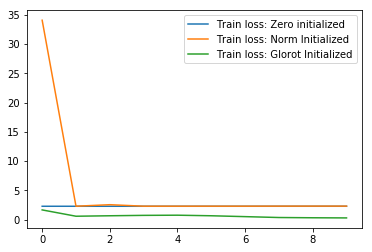

In [42]:
#Zero Weight Initialization
print "Zero weight initialization"
lr=1e-4
ZeroInitNet = MLP_MNIST([28*28,500,200],10)
params = list(ZeroInitNet.parameters())
for p in params:
    nn.init.uniform(p,0,0)
    
zero_losses = init_train(ZeroInitNet,mnist_train,lr,128)

print "Normal weight initialization mean of zero, variance of 1"
lr=1e-3
NormInitNet = MLP_MNIST([28*28,500,200],10)
params = list(NormInitNet.parameters())
for p in params:
    if len(p.size()) > 1:
        nn.init.normal(p,0,1)
    else:
        nn.init.uniform(p,0,0)
norm_losses = init_train(NormInitNet,mnist_train,lr,128)

print " Glorot Initialization"
lr=1e-5
GlorotInitNet = MLP_MNIST([28*28,500,200],10)
GlorotInit_Net = GlorotInitialize(GlorotInitNet)
glorot_losses = init_train(GlorotInit_Net,mnist_train,lr,128)

plt.plot(zero_losses,label='Train loss: Zero initialized ')
plt.plot(norm_losses,label='Train loss: Norm Initialized')
plt.plot(glorot_losses,label='Train loss: Glorot Initialized')
plt.legend()
plt.show()
    

# Initialization Comments
# GC we're asked to comment on the different results from the short training tests above.  All networks are identical (learning rates are not) and we need to discuss why each performed differently.
First it should be noted that the loss remains unchanged when using 0 weight intialization.  This can be attributed to the fact that each neuron will output the same value during forward propagation. When considering back propagation, each neuron will follow the same gradient and change identically. Thus the network will learn nothing.

Second, when intializing values using a normal distribution, the intial loss is very high.  This is because the intialization values can be large and output values 

# Learning Curves

In [114]:
#returns the best instance in training of the model to be trained as well as the loss and accuracy
#for both train and val if available.
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        else:
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    

            
def hyperparamsearch(num_epochs, hparams, trainLoader, valLoader, testLoader = None):
    bestNetwork = 0
    bestValAcc = 0
    for layer in hparams['layers']:
        for lr in hparams['lr']:
            for decay in hparams['lr_decay']:
                print "Neural Net Hyper params:"
                print "Layers: " + repr(layer)
                print "Learning Rate: " + repr(lr)
                print "Learning rate decay: " + repr(decay)
                epoch_loss = [0] * num_epochs
                NeuralNet = MLP_MNIST(layer,10)
                NeuralNet = GlorotInitialize(NeuralNet)
                optimizer = torch.optim.Adagrad(NeuralNet.parameters(), lr=lr,lr_decay = decay)

                    
                network, loss_history, train_accuracy, val_accuracy,test_accuracy = train(NeuralNet,num_epochs, trainLoader,optimizer,valLoader)
                if (max(val_accuracy) > bestValAcc):
                    bestNetwork = network
                    bestValAcc = max(val_accuracy)
                plt.plot(train_accuracy)
                plt.plot(val_accuracy)
                if (testLoader != None):
                    plt.plot(test_accuracy)
                plt.show()
                    
    return bestNetwork, bestValAcc

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.261  Train Accuracy: 0.924 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.102  Train Accuracy: 0.968 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.063  Train Accuracy: 0.980 Validation Accuracy: 0.973
Epoch : 4 Loss : 0.045  Train Accuracy: 0.986 Validation Accuracy: 0.973
Epoch : 5 Loss : 0.029  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.020  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 7 Loss : 0.015  Train Accuracy: 0.996 Validation Accuracy: 0.974
Epoch : 8 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.977
Epoch : 9 Loss : 0.007  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.977
Epoch : 13 Loss : 0.002

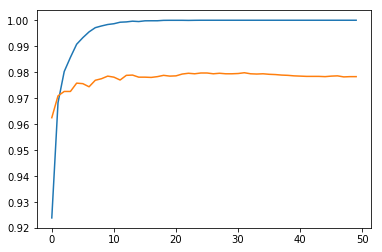

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.930  Train Accuracy: 0.790 Validation Accuracy: 0.886
Epoch : 2 Loss : 0.405  Train Accuracy: 0.886 Validation Accuracy: 0.909
Epoch : 3 Loss : 0.330  Train Accuracy: 0.904 Validation Accuracy: 0.920
Epoch : 4 Loss : 0.297  Train Accuracy: 0.914 Validation Accuracy: 0.925
Epoch : 5 Loss : 0.273  Train Accuracy: 0.921 Validation Accuracy: 0.930
Epoch : 6 Loss : 0.256  Train Accuracy: 0.926 Validation Accuracy: 0.934
Epoch : 7 Loss : 0.241  Train Accuracy: 0.931 Validation Accuracy: 0.937
Epoch : 8 Loss : 0.229  Train Accuracy: 0.934 Validation Accuracy: 0.939
Epoch : 9 Loss : 0.219  Train Accuracy: 0.937 Validation Accuracy: 0.941
Epoch : 10 Loss : 0.210  Train Accuracy: 0.940 Validation Accuracy: 0.943
Epoch : 11 Loss : 0.203  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 12 Loss : 0.196  Train Accuracy: 0.944 Validation Accuracy: 0.946
Epoch : 13 Loss : 0.19

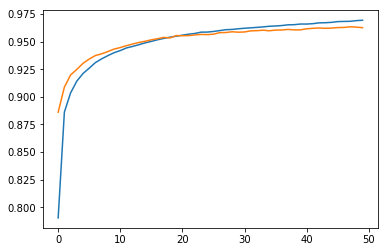

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.125  Train Accuracy: 0.273 Validation Accuracy: 0.431
Epoch : 2 Loss : 1.970  Train Accuracy: 0.504 Validation Accuracy: 0.595
Epoch : 3 Loss : 1.876  Train Accuracy: 0.609 Validation Accuracy: 0.667
Epoch : 4 Loss : 1.804  Train Accuracy: 0.662 Validation Accuracy: 0.704
Epoch : 5 Loss : 1.745  Train Accuracy: 0.690 Validation Accuracy: 0.729
Epoch : 6 Loss : 1.695  Train Accuracy: 0.709 Validation Accuracy: 0.744
Epoch : 7 Loss : 1.652  Train Accuracy: 0.723 Validation Accuracy: 0.755
Epoch : 8 Loss : 1.613  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 9 Loss : 1.579  Train Accuracy: 0.743 Validation Accuracy: 0.772
Epoch : 10 Loss : 1.549  Train Accuracy: 0.750 Validation Accuracy: 0.777
Epoch : 11 Loss : 1.521  Train Accuracy: 0.755 Validation Accuracy: 0.783
Epoch : 12 Loss : 1.496  Train Accuracy: 0.760 Validation Accuracy: 0.788
Epoch : 13 Loss : 1.473

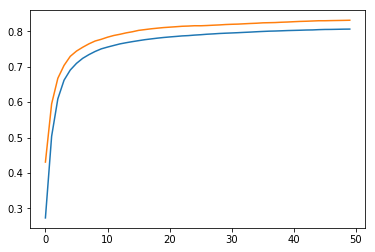

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.242  Train Accuracy: 0.927 Validation Accuracy: 0.957
Epoch : 2 Loss : 0.093  Train Accuracy: 0.972 Validation Accuracy: 0.972
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.034  Train Accuracy: 0.989 Validation Accuracy: 0.975
Epoch : 5 Loss : 0.023  Train Accuracy: 0.992 Validation Accuracy: 0.975
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.011  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001

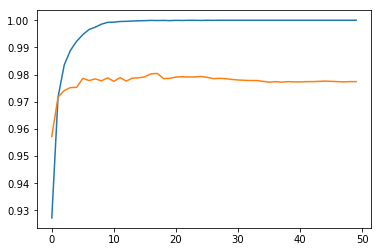

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.793  Train Accuracy: 0.818 Validation Accuracy: 0.896
Epoch : 2 Loss : 0.352  Train Accuracy: 0.898 Validation Accuracy: 0.915
Epoch : 3 Loss : 0.295  Train Accuracy: 0.914 Validation Accuracy: 0.927
Epoch : 4 Loss : 0.265  Train Accuracy: 0.924 Validation Accuracy: 0.932
Epoch : 5 Loss : 0.243  Train Accuracy: 0.930 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.226  Train Accuracy: 0.935 Validation Accuracy: 0.941
Epoch : 7 Loss : 0.213  Train Accuracy: 0.939 Validation Accuracy: 0.942
Epoch : 8 Loss : 0.202  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 9 Loss : 0.191  Train Accuracy: 0.945 Validation Accuracy: 0.947
Epoch : 10 Loss : 0.181  Train Accuracy: 0.948 Validation Accuracy: 0.951
Epoch : 11 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.953
Epoch : 12 Loss : 0.165  Train Accuracy: 0.952 Validation Accuracy: 0.954
Epoch : 13 Loss : 0.15

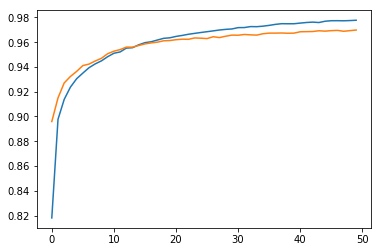

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.121  Train Accuracy: 0.360 Validation Accuracy: 0.544
Epoch : 2 Loss : 1.944  Train Accuracy: 0.589 Validation Accuracy: 0.663
Epoch : 3 Loss : 1.836  Train Accuracy: 0.663 Validation Accuracy: 0.708
Epoch : 4 Loss : 1.753  Train Accuracy: 0.697 Validation Accuracy: 0.734
Epoch : 5 Loss : 1.685  Train Accuracy: 0.719 Validation Accuracy: 0.752
Epoch : 6 Loss : 1.628  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 7 Loss : 1.578  Train Accuracy: 0.745 Validation Accuracy: 0.774
Epoch : 8 Loss : 1.535  Train Accuracy: 0.753 Validation Accuracy: 0.781
Epoch : 9 Loss : 1.496  Train Accuracy: 0.759 Validation Accuracy: 0.788
Epoch : 10 Loss : 1.462  Train Accuracy: 0.764 Validation Accuracy: 0.792
Epoch : 11 Loss : 1.431  Train Accuracy: 0.769 Validation Accuracy: 0.796
Epoch : 12 Loss : 1.403  Train Accuracy: 0.773 Validation Accuracy: 0.800
Epoch : 13 Loss : 1.377

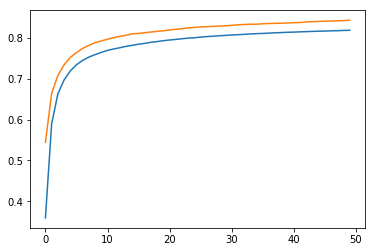

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.227  Train Accuracy: 0.932 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.085  Train Accuracy: 0.974 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.975
Epoch : 4 Loss : 0.032  Train Accuracy: 0.990 Validation Accuracy: 0.978
Epoch : 5 Loss : 0.021  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.978
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.002

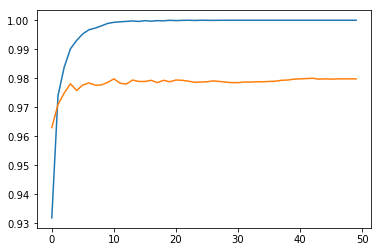

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.672  Train Accuracy: 0.843 Validation Accuracy: 0.909
Epoch : 2 Loss : 0.313  Train Accuracy: 0.909 Validation Accuracy: 0.927
Epoch : 3 Loss : 0.270  Train Accuracy: 0.923 Validation Accuracy: 0.934
Epoch : 4 Loss : 0.239  Train Accuracy: 0.933 Validation Accuracy: 0.939
Epoch : 5 Loss : 0.216  Train Accuracy: 0.940 Validation Accuracy: 0.944
Epoch : 6 Loss : 0.201  Train Accuracy: 0.943 Validation Accuracy: 0.946
Epoch : 7 Loss : 0.187  Train Accuracy: 0.946 Validation Accuracy: 0.949
Epoch : 8 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.954
Epoch : 9 Loss : 0.160  Train Accuracy: 0.954 Validation Accuracy: 0.954
Epoch : 10 Loss : 0.149  Train Accuracy: 0.957 Validation Accuracy: 0.958
Epoch : 11 Loss : 0.142  Train Accuracy: 0.959 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.135  Train Accuracy: 0.962 Validation Accuracy: 0.960
Epoch : 13 Loss : 0.12

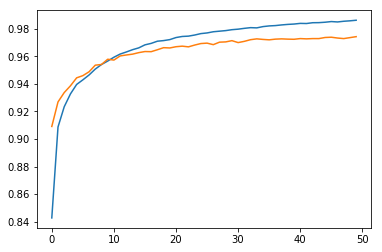

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.074  Train Accuracy: 0.443 Validation Accuracy: 0.651
Epoch : 2 Loss : 1.863  Train Accuracy: 0.673 Validation Accuracy: 0.729
Epoch : 3 Loss : 1.734  Train Accuracy: 0.719 Validation Accuracy: 0.759
Epoch : 4 Loss : 1.636  Train Accuracy: 0.741 Validation Accuracy: 0.773
Epoch : 5 Loss : 1.555  Train Accuracy: 0.756 Validation Accuracy: 0.786
Epoch : 6 Loss : 1.487  Train Accuracy: 0.767 Validation Accuracy: 0.795
Epoch : 7 Loss : 1.429  Train Accuracy: 0.775 Validation Accuracy: 0.801
Epoch : 8 Loss : 1.378  Train Accuracy: 0.782 Validation Accuracy: 0.806
Epoch : 9 Loss : 1.334  Train Accuracy: 0.786 Validation Accuracy: 0.811
Epoch : 10 Loss : 1.294  Train Accuracy: 0.791 Validation Accuracy: 0.815
Epoch : 11 Loss : 1.259  Train Accuracy: 0.794 Validation Accuracy: 0.818
Epoch : 12 Loss : 1.227  Train Accuracy: 0.797 Validation Accuracy: 0.820
Epoch : 13 Loss : 1.198

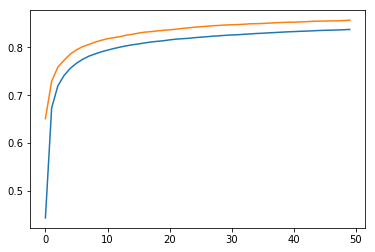

In [152]:
#Hyper parameter search

hparams = {
    "layers": [[28*28,500,250], [28*28,500,500],[28*28,650,650]],
    "lr": [1e-3,1e-4,1e-5],
    "lr_decay": [10e-5]
}

bestModel, bestValAcc = hyperparamsearch(50, hparams, mnist_train, mnist_val)
                

In [153]:
print bestModel
print bestValAcc

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
0.9804


The best model was had the following hyperparameters:
[784, 500, 500]
0.001
0.0001


In [154]:
#Training the best model for 100 epochs
layers = [784, 500, 500]
lr = 0.001
lr_decay=0.0001
model = MLP_MNIST(layers,10)
model = GlorotInitialize(model)
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay = lr_decay)
train_results = train(model,100,mnist_train,optimizer,mnist_val)

Epoch : 1 Loss : 0.253  Train Accuracy: 0.925 Validation Accuracy: 0.959
Epoch : 2 Loss : 0.095  Train Accuracy: 0.971 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.055  Train Accuracy: 0.982 Validation Accuracy: 0.972
Epoch : 4 Loss : 0.035  Train Accuracy: 0.989 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.022  Train Accuracy: 0.993 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.006  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 14 Loss : 0.001  Train Accuracy: 1.000 

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)


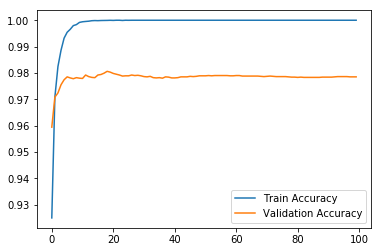

In [155]:
(bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results

print bestNetwork

plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label= 'Validation Accuracy')
plt.legend()
plt.show()

## Doubling the number of parameters



In [159]:
print 'Best validation accuracy: ' + repr(bestValAcc)
print 'Best model: ' + repr(bestModel)
params = list(bestModel.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
print ('Total number of parameters in best model: %d' %sum_params)
print 2*sum_params

Best validation accuracy: 0.9804
Best model: MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
torch.Size([500, 784])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in best model: 648010
1296020


Currently there are: (784+(784*500) + 800+(800*450)+ (450*10)+450+ 10) = 992,960 parameters


(in_size+(in_size*size1) + size1 + (size1*size2) + size2 + (size2*outsize) + outsize

We would like to create a new model with twice as many parameters, 1,985,920 parameters.



In [165]:
layerDims = [784,1005,500]
lr=0.001
lr_decay = 0.0001
Double_NN = MLP_MNIST(layerDims,10)
params = list(Double_NN.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
        
print ('Total number of parameters in double size model: %d' %sum_params)

torch.Size([1005, 784])
torch.Size([1005])
torch.Size([500, 1005])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in double size model: 1296935


In [166]:
Double_NN = GlorotInitialize(Double_NN)
optimizer = torch.optim.Adagrad(Double_NN.parameters(), lr=lr,lr_decay=lr_decay)
(Double_NN, epoch_loss, double_train_accuracy, double_val_accuracy, double_test_acc) = train(Double_NN,100,mnist_train,optimizer,mnist_val)


Epoch : 1 Loss : 0.219  Train Accuracy: 0.934 Validation Accuracy: 0.967
Epoch : 2 Loss : 0.081  Train Accuracy: 0.975 Validation Accuracy: 0.975
Epoch : 3 Loss : 0.048  Train Accuracy: 0.985 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.027  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.017  Train Accuracy: 0.994 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.011  Train Accuracy: 0.996 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.980
Epoch : 8 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 9 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 14 Loss : 0.000  Train Accuracy: 1.000 

In [167]:
print max(double_val_accuracy)

0.98


## Why does a network with double the size perform worse on the validation set?
## GC: Here we need to explain why the model with double the capacity performed worse than the best model with half the capacity
Here we have not increased regularization within the network.  By doubling the capacity of the model, we have also increased the inherent variance found within the model.  While the bias may have been reduced, the model now has an increased error from variance.

# Training Set Size, Generalization Gap, and Standard Error

First we'll randomly sample subsets of the training data


In [169]:
alphas = [0.01,0.02,0.05,0.1,1.0]
TRAINSIZE = mnist_train_data.shape[0]
indices = list(range(TRAINSIZE))

#Hyperparameters for model
layerDims = [784,500,500]
lr=0.001
lr_decay = .0001
batch_size=128
repeat_test_results = [{}]*5
for i in range(1,5):
    for alpha in alphas:
        subindices = np.random.choice(indices,size=[int(alpha*TRAINSIZE)])
        train_data_subset = mnist_train_data[indices,:]
        train_labels_subset = mnist_train_labels[indices]
        train_data_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data_subset),torch.IntTensor(train_labels_subset))

        subtrainloader = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size, shuffle=True, num_workers=2)
        model = MLP_MNIST(layerDims,10,dropout)
        optimizer = torch.optim.Adagrad(model.parameters(),lr=lr, lr_decay=lr_decay)
        repeat_test_results[i][alpha] = train(model,100,subtrainloader,optimizer,mnist_val,mnist_test)


Epoch : 1 Loss : 0.385  Train Accuracy: 0.894 Validation Accuracy: 0.947 Test Accuracy: 0.943
Epoch : 2 Loss : 0.151  Train Accuracy: 0.954 Validation Accuracy: 0.962 Test Accuracy: 0.959
Epoch : 3 Loss : 0.103  Train Accuracy: 0.969 Validation Accuracy: 0.967 Test Accuracy: 0.968
Epoch : 4 Loss : 0.075  Train Accuracy: 0.976 Validation Accuracy: 0.969 Test Accuracy: 0.965
Epoch : 5 Loss : 0.057  Train Accuracy: 0.982 Validation Accuracy: 0.974 Test Accuracy: 0.974
Epoch : 6 Loss : 0.040  Train Accuracy: 0.987 Validation Accuracy: 0.974 Test Accuracy: 0.974
Epoch : 7 Loss : 0.031  Train Accuracy: 0.991 Validation Accuracy: 0.974 Test Accuracy: 0.974
Epoch : 8 Loss : 0.024  Train Accuracy: 0.992 Validation Accuracy: 0.979 Test Accuracy: 0.976
Epoch : 9 Loss : 0.017  Train Accuracy: 0.994 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 10 Loss : 0.013  Train Accuracy: 0.996 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 11 Loss : 0.009  Train Accuracy: 0.997 Validation A

Epoch : 88 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 89 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 90 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 91 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 92 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 93 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 94 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 95 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 96 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 97 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 98 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 75 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 76 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 77 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 78 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 79 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 80 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 82 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 83 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 84 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.979
Epoch : 85 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 62 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 63 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 64 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 65 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 66 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 67 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 68 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 69 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 70 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 71 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.976
Epoch : 72 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 49 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 50 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 51 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 52 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 53 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 54 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 55 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 56 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 57 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 58 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 59 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 36 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.979
Epoch : 37 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.979
Epoch : 38 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.979
Epoch : 39 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.979
Epoch : 40 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 42 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 43 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 44 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 45 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.978
Epoch : 46 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 23 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 24 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 25 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 26 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 27 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 28 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 29 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 30 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 31 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 32 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 33 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 10 Loss : 0.014  Train Accuracy: 0.995 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 11 Loss : 0.011  Train Accuracy: 0.996 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 12 Loss : 0.007  Train Accuracy: 0.998 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 13 Loss : 0.006  Train Accuracy: 0.998 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 14 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 15 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 16 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 17 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 18 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 19 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 20 Loss : 0.001  Train Accuracy: 1.000 Val

Epoch : 97 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 98 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 99 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 100 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 1 Loss : 0.385  Train Accuracy: 0.893 Validation Accuracy: 0.950 Test Accuracy: 0.943
Epoch : 2 Loss : 0.160  Train Accuracy: 0.952 Validation Accuracy: 0.958 Test Accuracy: 0.955
Epoch : 3 Loss : 0.104  Train Accuracy: 0.968 Validation Accuracy: 0.968 Test Accuracy: 0.967
Epoch : 4 Loss : 0.075  Train Accuracy: 0.976 Validation Accuracy: 0.970 Test Accuracy: 0.969
Epoch : 5 Loss : 0.055  Train Accuracy: 0.983 Validation Accuracy: 0.971 Test Accuracy: 0.972
Epoch : 6 Loss : 0.039  Train Accuracy: 0.988 Validation Accuracy: 0.973 Test Accuracy: 0.975
Epoch : 7 Loss : 0.027  Train Accuracy: 0.991 Validatio

Epoch : 84 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.979
Epoch : 85 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 86 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 87 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 88 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 89 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 90 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 91 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 92 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 93 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 94 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 71 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 72 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 73 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 74 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 75 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 76 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 77 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 78 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 79 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 80 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 58 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 59 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 60 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 62 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 63 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 64 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 65 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 66 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 67 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 68 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 45 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.977
Epoch : 46 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.977
Epoch : 47 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 48 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 49 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 50 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 51 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 52 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 53 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 54 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 55 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 32 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 33 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 34 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 35 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 36 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 37 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 38 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.979
Epoch : 39 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 40 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 42 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 19 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.979
Epoch : 20 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 21 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.978
Epoch : 22 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 23 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 24 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 25 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 26 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 27 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 28 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 29 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 6 Loss : 0.033  Train Accuracy: 0.989 Validation Accuracy: 0.975 Test Accuracy: 0.974
Epoch : 7 Loss : 0.024  Train Accuracy: 0.992 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 8 Loss : 0.018  Train Accuracy: 0.994 Validation Accuracy: 0.975 Test Accuracy: 0.976
Epoch : 9 Loss : 0.013  Train Accuracy: 0.996 Validation Accuracy: 0.977 Test Accuracy: 0.976
Epoch : 10 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 11 Loss : 0.008  Train Accuracy: 0.997 Validation Accuracy: 0.976 Test Accuracy: 0.974
Epoch : 12 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 13 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 14 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 15 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 16 Loss : 0.002  Train Accuracy: 0.999 Validat

Epoch : 93 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 94 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 95 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 96 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 97 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 98 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 99 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 100 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.977
Epoch : 1 Loss : 0.374  Train Accuracy: 0.895 Validation Accuracy: 0.944 Test Accuracy: 0.943
Epoch : 2 Loss : 0.154  Train Accuracy: 0.953 Validation Accuracy: 0.965 Test Accuracy: 0.960
Epoch : 3 Loss : 0.096  Train Accuracy: 0.970 Valid

Epoch : 80 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 82 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 83 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 84 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 85 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 86 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.979
Epoch : 87 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 88 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 89 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 90 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 67 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.979
Epoch : 68 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.979
Epoch : 69 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.980 Test Accuracy: 0.978
Epoch : 70 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 71 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 72 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 73 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 74 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 75 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 76 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 77 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 54 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 55 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 56 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 57 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 58 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 59 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 60 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 62 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 63 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.976 Test Accuracy: 0.978
Epoch : 64 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 42 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 43 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 44 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 45 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 46 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 47 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 48 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 49 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 50 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 51 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 28 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 29 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 30 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 31 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 32 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 33 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 34 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 35 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 36 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.978
Epoch : 37 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.978
Epoch : 38 Loss : 0.000  Train Accuracy: 1.000 Val

Epoch : 15 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 16 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 17 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.976
Epoch : 18 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.976
Epoch : 19 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.977 Test Accuracy: 0.977
Epoch : 20 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 21 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 22 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.976
Epoch : 23 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.978 Test Accuracy: 0.977
Epoch : 24 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.979 Test Accuracy: 0.977
Epoch : 25 Loss : 0.000  Train Accuracy: 1.000 Val

In [186]:
#print repeat_test_results[0][0.05][5]

def GeneralizationGap(results):
    gen_gap_error = np.zeros(shape=(5,5))
    for i in range(0,5):
        for j,alpha in enumerate([0.01,0.02,0.05,0.1,1.0]):
            best_epoch = np.argmax(results[i][alpha][3])
            gen_gap_error[i,j] = results[i][alpha][2][int(best_epoch)] - results[i][alpha][4][int(best_epoch)]
            
    return gen_gap_error


alpha_results = GeneralizationGap(repeat_test_results)
for i in range(0,5):
    print "Alpha: " + repr(alphas[i])
    for j in range(0,5):
        print alpha_results[j,i]

Alpha: 0.01
0.02
0.02
0.02
0.02
0.02
Alpha: 0.02
0.02226
0.02226
0.02226
0.02226
0.02226
Alpha: 0.05
0.02166
0.02166
0.02166
0.02166
0.02166
Alpha: 0.1
0.0228
0.0228
0.0228
0.0228
0.0228
Alpha: 1.0
0.0228
0.0228
0.0228
0.0228
0.0228


| Alpha  | Result 1 | Result 2 |  Result 3 |  Result 4 |  Result 5 |
|--------|----------|----------|-----------|-----------|-----------|
|  0.01  |   0.02   |   0.02   |    0.02   |    0.02   |   0.02    |
|  0.02  |   0.02226|   0.02226|   0.02226 |   0.02226 |   0.02226 |
|  0.05  | 0.021666 | 0.021666 |  0.021666 |  0.021666 |  0.021666 |
|  0.1   | 0.0228   | 0.0228   |  0.0228   |  0.0228   |  0.0228   |
|  1.0   | 0.0228   | 0.0228   | 0.0228    |  0.0228   |  0.0228   |

#### Problem 2

In [3]:
from sklearn.preprocessing import StandardScaler

import numpy as np
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

In [4]:
class MLP_20(nn.Module):
    
    def __init__(self,insize,outsize):
        super(MLP_20,self).__init__()
        self.fc1 = nn.Linear(insize,100)
        self.fc2 = nn.Linear(100,outsize)
        self.insize = insize
        
    def forward(self,x):
        a1 = self.fc1(x)
        h1 = nn.functional.relu(a1)
        
        logits = self.fc2(h1)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [5]:
def restructure_data(data):
    samples, vocab_size, max_word_count = np.max(data,axis=0)
    restructured_data = np.zeros((int(samples),int(vocab_size)))
    for i in range(len(data)):
        if (data[i,1]-1)<=vocab_size:
            restructured_data[int(data[i,0]-1),int(data[i,1]-1)]=data[i,2]
    return restructured_data

def tfidf(data):
    idf =  np.log(np.divide((data.shape[0]*np.ones_like(data)),1+np.sum(np.equal(data>0,1),axis=0)[None,:].astype(np.float)))
    print idf[0:10,:]
    #tf = 0.5+0.5*np.divide(data,np.max(data,axis=1)[:,None].astype(np.float))
    return np.multiply(data,idf)

def make_loaders(data,labels,val_split,test_data=None,test_labels=None,batch_size=128):
    val_loader = 0
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    split = int(val_split*indices.shape[0])
    train_data, val_data = data[indices[:split],:], data[indices[split:],:]
    train_labels, val_labels = labels[indices[:split]], labels[indices[split:]]
    del indices
    print train_data.shape, train_labels.shape
    print val_data.shape, val_labels.shape
    
    train_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data),torch.IntTensor(train_labels))
    del train_data
    del train_labels
    train_loader = torch.utils.data.DataLoader(train_tensor,batch_size=batch_size, shuffle = True)
    del train_tensor
    if val_split<1:
        val_tensor = torch.utils.data.TensorDataset(torch.Tensor(val_data), torch.IntTensor(val_labels))
        del val_data
        del val_labels
        val_loader = torch.utils.data.DataLoader(val_tensor,batch_size=batch_size, shuffle = True)
        del val_tensor
        
    if (type(test_data) != type(None)):
        test_tensor = torch.utils.data.TensorDataset(torch.Tensor(test_data),torch.IntTensor(test_labels))
        test_loader = torch.utils.data.DataLoader(test_tensor,batch_size=batch_size, shuffle = True)
        return train_loader, val_loader, test_loader

    return train_loader, val_loader


def standardize_data(data):
    s = StandardScaler()
    s.fit(data)
    s.var_ += 1e-5
    standardized_data = s.transform(data)
    return standardized_data

In [7]:
data = restructure_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
print test_data.shape

(11269, 53975)
(7505, 61188)
(7505, 53975)


(11269, 53975)
(7505, 61188)
(9015, 53975) (9015,)
(2254, 53975) (2254,)
Learning rate: 1e-06
Epoch : 1 Loss : 3.018  Train Accuracy: 0.046 Validation Accuracy: 0.067 Test Accuracy: 0.061
Epoch : 2 Loss : 2.988  Train Accuracy: 0.061 Validation Accuracy: 0.070 Test Accuracy: 0.068
Epoch : 3 Loss : 2.957  Train Accuracy: 0.076 Validation Accuracy: 0.098 Test Accuracy: 0.089
Epoch : 4 Loss : 2.919  Train Accuracy: 0.121 Validation Accuracy: 0.143 Test Accuracy: 0.120
Epoch : 5 Loss : 2.872  Train Accuracy: 0.147 Validation Accuracy: 0.155 Test Accuracy: 0.136
Epoch : 6 Loss : 2.828  Train Accuracy: 0.161 Validation Accuracy: 0.180 Test Accuracy: 0.169
Epoch : 7 Loss : 2.758  Train Accuracy: 0.225 Validation Accuracy: 0.219 Test Accuracy: 0.200
Epoch : 8 Loss : 2.699  Train Accuracy: 0.257 Validation Accuracy: 0.255 Test Accuracy: 0.223
Epoch : 9 Loss : 2.621  Train Accuracy: 0.306 Validation Accuracy: 0.311 Test Accuracy: 0.263
Epoch : 10 Loss : 2.581  Train Accuracy: 0.314 Validation Ac

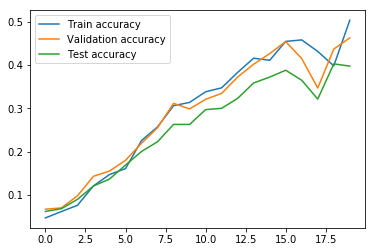

Learning rate: 1e-07
Epoch : 1 Loss : 3.030  Train Accuracy: 0.040 Validation Accuracy: 0.042 Test Accuracy: 0.040
Epoch : 2 Loss : 3.007  Train Accuracy: 0.040 Validation Accuracy: 0.049 Test Accuracy: 0.042
Epoch : 3 Loss : 2.993  Train Accuracy: 0.045 Validation Accuracy: 0.063 Test Accuracy: 0.049
Epoch : 4 Loss : 2.983  Train Accuracy: 0.053 Validation Accuracy: 0.070 Test Accuracy: 0.053
Epoch : 5 Loss : 2.975  Train Accuracy: 0.061 Validation Accuracy: 0.071 Test Accuracy: 0.055
Epoch : 6 Loss : 2.965  Train Accuracy: 0.064 Validation Accuracy: 0.072 Test Accuracy: 0.060
Epoch : 7 Loss : 2.953  Train Accuracy: 0.071 Validation Accuracy: 0.083 Test Accuracy: 0.065
Epoch : 8 Loss : 2.941  Train Accuracy: 0.080 Validation Accuracy: 0.086 Test Accuracy: 0.074
Epoch : 9 Loss : 2.932  Train Accuracy: 0.092 Validation Accuracy: 0.102 Test Accuracy: 0.083
Epoch : 10 Loss : 2.922  Train Accuracy: 0.106 Validation Accuracy: 0.115 Test Accuracy: 0.095
Epoch : 11 Loss : 2.909  Train Accurac

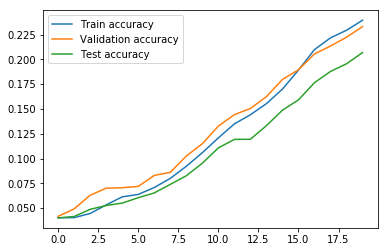

Learning rate: 1e-08
Epoch : 1 Loss : 3.043  Train Accuracy: 0.061 Validation Accuracy: 0.063 Test Accuracy: 0.064
Epoch : 2 Loss : 3.039  Train Accuracy: 0.063 Validation Accuracy: 0.064 Test Accuracy: 0.066
Epoch : 3 Loss : 3.033  Train Accuracy: 0.065 Validation Accuracy: 0.063 Test Accuracy: 0.067
Epoch : 4 Loss : 3.024  Train Accuracy: 0.064 Validation Accuracy: 0.064 Test Accuracy: 0.067
Epoch : 5 Loss : 3.016  Train Accuracy: 0.059 Validation Accuracy: 0.059 Test Accuracy: 0.064
Epoch : 6 Loss : 3.013  Train Accuracy: 0.054 Validation Accuracy: 0.053 Test Accuracy: 0.058
Epoch : 7 Loss : 3.010  Train Accuracy: 0.055 Validation Accuracy: 0.051 Test Accuracy: 0.054
Epoch : 8 Loss : 3.009  Train Accuracy: 0.056 Validation Accuracy: 0.050 Test Accuracy: 0.053
Epoch : 9 Loss : 3.007  Train Accuracy: 0.056 Validation Accuracy: 0.049 Test Accuracy: 0.052
Epoch : 10 Loss : 3.002  Train Accuracy: 0.057 Validation Accuracy: 0.049 Test Accuracy: 0.050
Epoch : 11 Loss : 2.998  Train Accurac

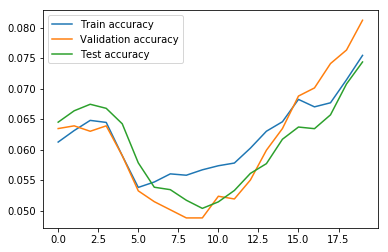

Learning rate: 1e-09
Epoch : 1 Loss : 3.007  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.053
Epoch : 2 Loss : 3.006  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.052
Epoch : 3 Loss : 3.005  Train Accuracy: 0.046 Validation Accuracy: 0.044 Test Accuracy: 0.053
Epoch : 4 Loss : 3.005  Train Accuracy: 0.047 Validation Accuracy: 0.044 Test Accuracy: 0.052
Epoch : 5 Loss : 3.004  Train Accuracy: 0.047 Validation Accuracy: 0.044 Test Accuracy: 0.052
Epoch : 6 Loss : 3.004  Train Accuracy: 0.047 Validation Accuracy: 0.045 Test Accuracy: 0.052
Epoch : 7 Loss : 3.002  Train Accuracy: 0.047 Validation Accuracy: 0.046 Test Accuracy: 0.053
Epoch : 8 Loss : 3.002  Train Accuracy: 0.048 Validation Accuracy: 0.047 Test Accuracy: 0.054
Epoch : 9 Loss : 3.001  Train Accuracy: 0.048 Validation Accuracy: 0.047 Test Accuracy: 0.054
Epoch : 10 Loss : 3.000  Train Accuracy: 0.051 Validation Accuracy: 0.049 Test Accuracy: 0.054
Epoch : 11 Loss : 2.998  Train Accurac

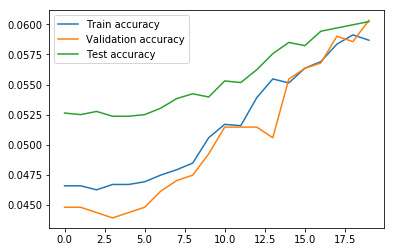

In [8]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]


train_loader_newsgroups, val_loader_newsgroups, test_loader_newsgroups = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data


lrs = [1e-4,1e-5,1e-6,1e-7]
models = [0]*len(lrs)
train_results = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models[i] = MLP_20(Vocab_size,20)
    models[i] = GlorotInitialize(models[i])
    optimizer = torch.optim.SGD(models[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results[i] = train(models[i],20,train_loader_newsgroups,optimizer,val_loader_newsgroups,test_loader_newsgroups)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

In [8]:
#TF-IDF Preprocessing
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
data = tfidf(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
test_data = tfidf(test_data)

train_loader_tfidf, val_loader_tfidf, test_loader_tfidf = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data

(11269, 53975)
(11269, 53975)
(7505, 61188)
(7505, 53975)
(9015, 53975) (9015,)
(2254, 53975) (2254,)


Learning rate: 0.001
Epoch : 1 Loss : 3.641  Train Accuracy: 0.463 Validation Accuracy: 0.545 Test Accuracy: 0.498
Epoch : 2 Loss : 23.806  Train Accuracy: 0.613 Validation Accuracy: 0.531 Test Accuracy: 0.444
Epoch : 3 Loss : 100.750  Train Accuracy: 0.616 Validation Accuracy: 0.513 Test Accuracy: 0.437
Epoch : 4 Loss : 299.960  Train Accuracy: 0.581 Validation Accuracy: 0.533 Test Accuracy: 0.460
Epoch : 5 Loss : 4742.845  Train Accuracy: 0.613 Validation Accuracy: 0.464 Test Accuracy: 0.395
Epoch : 6 Loss : 15556.319  Train Accuracy: 0.527 Validation Accuracy: 0.410 Test Accuracy: 0.344
Epoch : 7 Loss : 6818.882  Train Accuracy: 0.466 Validation Accuracy: 0.384 Test Accuracy: 0.334
Epoch : 8 Loss : 1285384.161  Train Accuracy: 0.424 Validation Accuracy: 0.340 Test Accuracy: 0.299
Epoch : 9 Loss : 759963.529  Train Accuracy: 0.382 Validation Accuracy: 0.331 Test Accuracy: 0.292
Epoch : 10 Loss : 374729.348  Train Accuracy: 0.391 Validation Accuracy: 0.354 Test Accuracy: 0.328
Epoch :

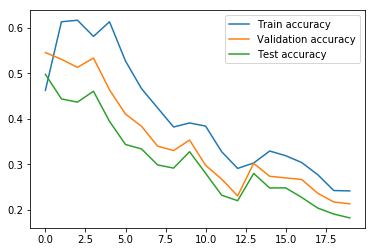

Learning rate: 0.0001
Epoch : 1 Loss : 2.398  Train Accuracy: 0.393 Validation Accuracy: 0.719 Test Accuracy: 0.640
Epoch : 2 Loss : 0.789  Train Accuracy: 0.842 Validation Accuracy: 0.783 Test Accuracy: 0.705
Epoch : 3 Loss : 1.435  Train Accuracy: 0.834 Validation Accuracy: 0.635 Test Accuracy: 0.541
Epoch : 4 Loss : 4.770  Train Accuracy: 0.773 Validation Accuracy: 0.737 Test Accuracy: 0.659
Epoch : 5 Loss : 2.866  Train Accuracy: 0.807 Validation Accuracy: 0.732 Test Accuracy: 0.624
Epoch : 6 Loss : 4.912  Train Accuracy: 0.748 Validation Accuracy: 0.633 Test Accuracy: 0.535
Epoch : 7 Loss : 13.443  Train Accuracy: 0.806 Validation Accuracy: 0.709 Test Accuracy: 0.602
Epoch : 8 Loss : 2.543  Train Accuracy: 0.818 Validation Accuracy: 0.741 Test Accuracy: 0.635
Epoch : 9 Loss : 3.095  Train Accuracy: 0.846 Validation Accuracy: 0.729 Test Accuracy: 0.614
Epoch : 10 Loss : 1.806  Train Accuracy: 0.897 Validation Accuracy: 0.733 Test Accuracy: 0.617
Epoch : 11 Loss : 12.957  Train Accu

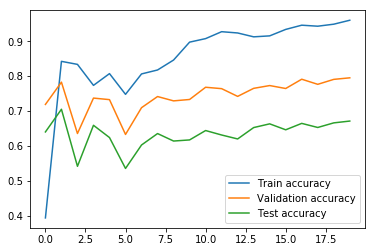

Learning rate: 1e-05
Epoch : 1 Loss : 2.955  Train Accuracy: 0.121 Validation Accuracy: 0.295 Test Accuracy: 0.259
Epoch : 2 Loss : 2.205  Train Accuracy: 0.567 Validation Accuracy: 0.659 Test Accuracy: 0.590
Epoch : 3 Loss : 1.359  Train Accuracy: 0.812 Validation Accuracy: 0.789 Test Accuracy: 0.714
Epoch : 4 Loss : 0.775  Train Accuracy: 0.874 Validation Accuracy: 0.825 Test Accuracy: 0.747
Epoch : 5 Loss : 0.483  Train Accuracy: 0.905 Validation Accuracy: 0.839 Test Accuracy: 0.754
Epoch : 6 Loss : 0.363  Train Accuracy: 0.917 Validation Accuracy: 0.841 Test Accuracy: 0.756
Epoch : 7 Loss : 0.294  Train Accuracy: 0.925 Validation Accuracy: 0.835 Test Accuracy: 0.757
Epoch : 8 Loss : 0.238  Train Accuracy: 0.942 Validation Accuracy: 0.854 Test Accuracy: 0.778
Epoch : 9 Loss : 0.222  Train Accuracy: 0.946 Validation Accuracy: 0.851 Test Accuracy: 0.769
Epoch : 10 Loss : 0.213  Train Accuracy: 0.952 Validation Accuracy: 0.805 Test Accuracy: 0.727
Epoch : 11 Loss : 0.261  Train Accurac

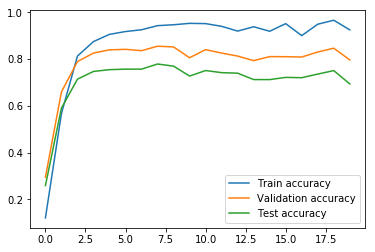

Learning rate: 1e-06
Epoch : 1 Loss : 3.117  Train Accuracy: 0.053 Validation Accuracy: 0.075 Test Accuracy: 0.062
Epoch : 2 Loss : 2.938  Train Accuracy: 0.104 Validation Accuracy: 0.153 Test Accuracy: 0.126
Epoch : 3 Loss : 2.720  Train Accuracy: 0.246 Validation Accuracy: 0.291 Test Accuracy: 0.246
Epoch : 4 Loss : 2.489  Train Accuracy: 0.433 Validation Accuracy: 0.442 Test Accuracy: 0.380
Epoch : 5 Loss : 2.234  Train Accuracy: 0.597 Validation Accuracy: 0.570 Test Accuracy: 0.497
Epoch : 6 Loss : 1.953  Train Accuracy: 0.705 Validation Accuracy: 0.654 Test Accuracy: 0.586
Epoch : 7 Loss : 1.659  Train Accuracy: 0.779 Validation Accuracy: 0.715 Test Accuracy: 0.645
Epoch : 8 Loss : 1.381  Train Accuracy: 0.825 Validation Accuracy: 0.755 Test Accuracy: 0.686
Epoch : 9 Loss : 1.141  Train Accuracy: 0.855 Validation Accuracy: 0.793 Test Accuracy: 0.712
Epoch : 10 Loss : 0.945  Train Accuracy: 0.872 Validation Accuracy: 0.812 Test Accuracy: 0.727
Epoch : 11 Loss : 0.791  Train Accurac

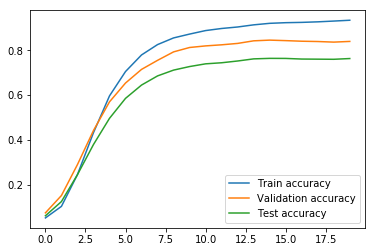

In [12]:
lrs = [1e-5,1e-6,1e-7,1e-8]
models_tfidf = [0]*len(lrs)
train_results_tfidf = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models_tfidf[i] = MLP_20(Vocab_size,20)
    models_tfidf[i] = GlorotInitialize(models_tfidf[i])
    optimizer = torch.optim.SGD(models_tfidf[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results_tfidf[i] = train(models_tfidf[i],20,train_loader_tfidf,optimizer,val_loader_tfidf,test_loader_tfidf)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results_tfidf[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

In [6]:
#Standardization preprocessing


In [6]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1

test_data = np.loadtxt('./data/20news-bydate/matlab/test.data')
test_labels = np.loadtxt('./data/20news-bydate/matlab/test.label')
test_labels -= 1

data = restructure_data(data)
data = standardize_data(data)
Vocab_size = data.shape[1]
test_data = restructure_data(test_data)[:,:Vocab_size]
test_data = standardize_data(test_data)

train_loader_std, val_loader_std, test_loader_std = make_loaders(data,labels,0.8,test_data,test_labels)
del data
del test_data

KeyboardInterrupt: 

Learning rate: 0.0001
Epoch : 1 Loss : 2.402  Train Accuracy: 0.356 Validation Accuracy: 0.726 Test Accuracy: 0.620
Epoch : 2 Loss : 0.257  Train Accuracy: 0.935 Validation Accuracy: 0.800 Test Accuracy: 0.676
Epoch : 3 Loss : 0.179  Train Accuracy: 0.965 Validation Accuracy: 0.817 Test Accuracy: 0.689
Epoch : 4 Loss : 0.210  Train Accuracy: 0.969 Validation Accuracy: 0.841 Test Accuracy: 0.711
Epoch : 5 Loss : 0.526  Train Accuracy: 0.963 Validation Accuracy: 0.839 Test Accuracy: 0.716
Epoch : 6 Loss : 0.572  Train Accuracy: 0.967 Validation Accuracy: 0.832 Test Accuracy: 0.702
Epoch : 7 Loss : 0.986  Train Accuracy: 0.968 Validation Accuracy: 0.818 Test Accuracy: 0.690
Epoch : 8 Loss : 1.752  Train Accuracy: 0.966 Validation Accuracy: 0.823 Test Accuracy: 0.699
Epoch : 9 Loss : 2.973  Train Accuracy: 0.964 Validation Accuracy: 0.816 Test Accuracy: 0.684
Epoch : 10 Loss : 0.705  Train Accuracy: 0.985 Validation Accuracy: 0.833 Test Accuracy: 0.697
Epoch : 11 Loss : 2.505  Train Accura

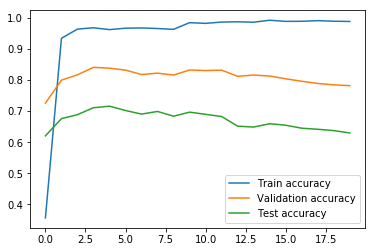

Learning rate: 1e-05
Epoch : 1 Loss : 3.428  Train Accuracy: 0.077 Validation Accuracy: 0.178 Test Accuracy: 0.149
Epoch : 2 Loss : 1.452  Train Accuracy: 0.678 Validation Accuracy: 0.628 Test Accuracy: 0.524
Epoch : 3 Loss : 0.491  Train Accuracy: 0.940 Validation Accuracy: 0.766 Test Accuracy: 0.656
Epoch : 4 Loss : 0.226  Train Accuracy: 0.957 Validation Accuracy: 0.779 Test Accuracy: 0.661
Epoch : 5 Loss : 0.161  Train Accuracy: 0.959 Validation Accuracy: 0.780 Test Accuracy: 0.658
Epoch : 6 Loss : 0.121  Train Accuracy: 0.970 Validation Accuracy: 0.796 Test Accuracy: 0.669
Epoch : 7 Loss : 0.088  Train Accuracy: 0.976 Validation Accuracy: 0.811 Test Accuracy: 0.676
Epoch : 8 Loss : 0.064  Train Accuracy: 0.984 Validation Accuracy: 0.831 Test Accuracy: 0.697
Epoch : 9 Loss : 0.059  Train Accuracy: 0.986 Validation Accuracy: 0.841 Test Accuracy: 0.708
Epoch : 10 Loss : 0.056  Train Accuracy: 0.986 Validation Accuracy: 0.850 Test Accuracy: 0.716
Epoch : 11 Loss : 0.047  Train Accurac

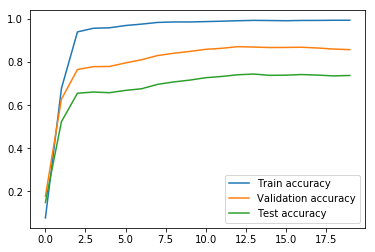

Learning rate: 1e-06
Epoch : 1 Loss : 3.648  Train Accuracy: 0.053 Validation Accuracy: 0.056 Test Accuracy: 0.058
Epoch : 2 Loss : 3.207  Train Accuracy: 0.094 Validation Accuracy: 0.093 Test Accuracy: 0.085
Epoch : 3 Loss : 2.542  Train Accuracy: 0.248 Validation Accuracy: 0.187 Test Accuracy: 0.155
Epoch : 4 Loss : 1.876  Train Accuracy: 0.513 Validation Accuracy: 0.345 Test Accuracy: 0.281
Epoch : 5 Loss : 1.340  Train Accuracy: 0.744 Validation Accuracy: 0.500 Test Accuracy: 0.407
Epoch : 6 Loss : 0.953  Train Accuracy: 0.864 Validation Accuracy: 0.610 Test Accuracy: 0.503
Epoch : 7 Loss : 0.692  Train Accuracy: 0.920 Validation Accuracy: 0.672 Test Accuracy: 0.564
Epoch : 8 Loss : 0.517  Train Accuracy: 0.945 Validation Accuracy: 0.714 Test Accuracy: 0.605
Epoch : 9 Loss : 0.395  Train Accuracy: 0.954 Validation Accuracy: 0.734 Test Accuracy: 0.629
Epoch : 10 Loss : 0.313  Train Accuracy: 0.956 Validation Accuracy: 0.751 Test Accuracy: 0.640
Epoch : 11 Loss : 0.257  Train Accurac

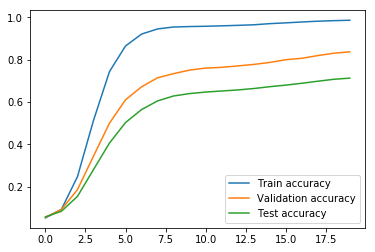

Learning rate: 1e-07
Epoch : 1 Loss : 3.759  Train Accuracy: 0.052 Validation Accuracy: 0.058 Test Accuracy: 0.052
Epoch : 2 Loss : 3.705  Train Accuracy: 0.056 Validation Accuracy: 0.058 Test Accuracy: 0.054
Epoch : 3 Loss : 3.593  Train Accuracy: 0.062 Validation Accuracy: 0.061 Test Accuracy: 0.058
Epoch : 4 Loss : 3.437  Train Accuracy: 0.073 Validation Accuracy: 0.066 Test Accuracy: 0.062
Epoch : 5 Loss : 3.242  Train Accuracy: 0.090 Validation Accuracy: 0.070 Test Accuracy: 0.070
Epoch : 6 Loss : 3.028  Train Accuracy: 0.122 Validation Accuracy: 0.083 Test Accuracy: 0.081
Epoch : 7 Loss : 2.804  Train Accuracy: 0.167 Validation Accuracy: 0.104 Test Accuracy: 0.100
Epoch : 8 Loss : 2.571  Train Accuracy: 0.231 Validation Accuracy: 0.134 Test Accuracy: 0.120
Epoch : 9 Loss : 2.340  Train Accuracy: 0.313 Validation Accuracy: 0.157 Test Accuracy: 0.148
Epoch : 10 Loss : 2.115  Train Accuracy: 0.406 Validation Accuracy: 0.195 Test Accuracy: 0.179
Epoch : 11 Loss : 1.901  Train Accurac

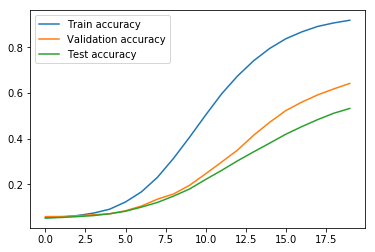

In [13]:
lrs = [1e-4,1e-5,1e-6,1e-7]
models_std = [0]*len(lrs)
train_results_std = [0]*len(lrs)
for i,lr in enumerate(lrs):
    print "Learning rate: " + repr(lr)
    models_std[i] = MLP_20(Vocab_size,20)
    models_std[i] = GlorotInitialize(models_std[i])
    optimizer = torch.optim.SGD(models_std[i].parameters(),lr=lr,momentum=0.9)
    loss_crit = nn.CrossEntropyLoss()
    train_results_std[i] = train(models_std[i],20,train_loader_std,optimizer,val_loader_std,test_loader_std)
    (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results_std[i]
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend()
    plt.show()

## Variance in Training

Best results from before:


Using the best performing network for this section. Standardization with learning rate 1e-5

In [17]:
def train_5000(model,train_loader,optimizer,loss_func):
    losses = [0]*5000
    batch_number = 0
    model = GlorotInitialize(model)
    for i in range(1000):
        for batch_index, (inputs, targets) in enumerate(train_loader):
            
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            loss = loss_func(logits,targets)
            
            loss.backward()
            optimizer.step()
            losses[batch_number] = (loss.data[0])
            print "Iteration: " + repr(batch_number + 1) + " Loss: " + repr(loss.data[0])
            batch_number += 1
            if batch_number == 5000:
                plt.plot(losses, label='Train losses')
                plt.legend()
                plt.show()
                return model,losses

(11269, 53975) (11269,)
(0, 53975) (0,)
Iteration: 1 Loss: Variable containing:
 4.3365
[torch.FloatTensor of size 1]

Iteration: 2 Loss: Variable containing:
 4.2725
[torch.FloatTensor of size 1]

Iteration: 3 Loss: Variable containing:
 15.2051
[torch.FloatTensor of size 1]

Iteration: 4 Loss: Variable containing:
 49.0164
[torch.FloatTensor of size 1]

Iteration: 5 Loss: Variable containing:
 106.3580
[torch.FloatTensor of size 1]

Iteration: 6 Loss: Variable containing:
 126.7990
[torch.FloatTensor of size 1]

Iteration: 7 Loss: Variable containing:
 2332.5491
[torch.FloatTensor of size 1]

Iteration: 8 Loss: Variable containing:
 7783.4409
[torch.FloatTensor of size 1]

Iteration: 9 Loss: Variable containing:
1.00000e+05 *
  1.0858
[torch.FloatTensor of size 1]

Iteration: 10 Loss: Variable containing:
 56449.0469
[torch.FloatTensor of size 1]

Iteration: 11 Loss: Variable containing:
1.00000e+06 *
  4.6409
[torch.FloatTensor of size 1]

Iteration: 12 Loss: Variable containing:
 3

Iteration: 107 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 108 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 109 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 110 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 111 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 112 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 113 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 114 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 115 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 116 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 117 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 118 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 119 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 215 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 216 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 217 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 218 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 219 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 220 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 221 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 222 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 223 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 224 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 225 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 226 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 227 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 333 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 334 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 335 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 336 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 337 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 338 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 339 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 340 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 341 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 342 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 343 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 344 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 345 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 452 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 453 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 454 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 455 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 456 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 457 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 458 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 459 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 460 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 461 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 462 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 463 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 464 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 563 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 564 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 565 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 566 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 567 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 568 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 569 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 570 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 571 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 572 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 573 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 574 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 575 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 670 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 671 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 672 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 673 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 674 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 675 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 676 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 677 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 678 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 679 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 680 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 681 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 682 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 781 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 782 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 783 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 784 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 785 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 786 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 787 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 788 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 789 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 790 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 791 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 792 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 793 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]


Iteration: 890 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 891 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 892 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 893 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 894 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 895 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 896 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 897 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 898 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 899 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 900 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 901 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 902 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]



Iteration: 1007 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1008 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1009 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1010 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1011 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1012 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1013 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1014 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1015 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1016 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1017 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1018 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1019 Loss: Variable containing:
nan
[torch.FloatTens

Iteration: 1121 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1122 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1123 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1124 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1125 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1126 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1127 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1128 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1129 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1130 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1131 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1132 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1133 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1239 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1240 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1241 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1242 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1243 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1244 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1245 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1246 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1247 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1248 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1249 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1250 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1251 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1349 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1350 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1351 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1352 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1353 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1354 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1355 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1356 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1357 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1358 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1359 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1360 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1361 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1457 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1458 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1459 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1460 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1461 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1462 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1463 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1464 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1465 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1466 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1467 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1468 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1469 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1566 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1567 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1568 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1569 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1570 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1571 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1572 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1573 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1574 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1575 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1576 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1577 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1578 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1677 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1678 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1679 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1680 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1681 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1682 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1683 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1684 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1685 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1686 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1687 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1688 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1689 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1783 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1784 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1785 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1786 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1787 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1788 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1789 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1790 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1791 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1792 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1793 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1794 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1795 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 1897 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1898 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1899 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1900 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1901 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1902 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1903 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1904 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1905 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1906 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1907 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1908 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 1909 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2007 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2008 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2009 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2010 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2011 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2012 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2013 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2014 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2015 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2016 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2017 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2018 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2019 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2122 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2123 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2124 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2125 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2126 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2127 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2128 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2129 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2130 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2131 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2132 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2133 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2134 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2238 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2239 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2240 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2241 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2242 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2243 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2244 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2245 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2246 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2247 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2248 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2249 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2250 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2357 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2358 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2359 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2360 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2361 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2362 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2363 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2364 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2365 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2366 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2367 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2368 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2369 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2475 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2476 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2477 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2478 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2479 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2480 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2481 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2482 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2483 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2484 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2485 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2486 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2487 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2591 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2592 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2593 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2594 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2595 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2596 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2597 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2598 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2599 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2600 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2601 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2602 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2603 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2706 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2707 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2708 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2709 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2710 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2711 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2712 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2713 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2714 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2715 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2716 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2717 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2718 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2824 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2825 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2826 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2827 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2828 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2829 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2830 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2831 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2832 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2833 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2834 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2835 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2836 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 2943 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2944 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2945 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2946 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2947 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2948 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2949 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2950 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2951 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2952 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2953 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2954 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 2955 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3062 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3063 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3064 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3065 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3066 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3067 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3068 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3069 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3070 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3071 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3072 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3073 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3074 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3182 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3183 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3184 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3185 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3186 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3187 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3188 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3189 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3190 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3191 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3192 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3193 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3194 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3299 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3300 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3301 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3302 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3303 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3304 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3305 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3306 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3307 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3308 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3309 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3310 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3311 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3418 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3419 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3420 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3421 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3422 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3423 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3424 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3425 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3426 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3427 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3428 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3429 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3430 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3537 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3538 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3539 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3540 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3541 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3542 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3543 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3544 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3545 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3546 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3547 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3548 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3549 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3656 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3657 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3658 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3659 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3660 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3661 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3662 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3663 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3664 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3665 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3666 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3667 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3668 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3776 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3777 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3778 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3779 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3780 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3781 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3782 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3783 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3784 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3785 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3786 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3787 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3788 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 3894 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3895 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3896 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3897 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3898 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3899 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3900 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3901 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3902 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3903 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3904 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3905 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 3906 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4014 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4015 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4016 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4017 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4018 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4019 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4020 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4021 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4022 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4023 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4024 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4025 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4026 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4133 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4134 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4135 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4136 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4137 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4138 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4139 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4140 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4141 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4142 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4143 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4144 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4145 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4253 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4254 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4255 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4256 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4257 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4258 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4259 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4260 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4261 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4262 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4263 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4264 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4265 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4372 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4373 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4374 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4375 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4376 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4377 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4378 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4379 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4380 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4381 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4382 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4383 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4384 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4491 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4492 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4493 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4494 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4495 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4496 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4497 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4498 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4499 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4500 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4501 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4502 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4503 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4610 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4611 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4612 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4613 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4614 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4615 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4616 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4617 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4618 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4619 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4620 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4621 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4622 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4721 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4722 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4723 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4724 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4725 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4726 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4727 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4728 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4729 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4730 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4731 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4732 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4733 Loss: Variable containing:
nan
[torch.FloatTenso

Iteration: 4840 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4841 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4842 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4843 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4844 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4845 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4846 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4847 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4848 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4849 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4850 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4851 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4852 Loss: Variable containing:
nan
[torch.FloatTenso


Iteration: 4958 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4959 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4960 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4961 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4962 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4963 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4964 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4965 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4966 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4967 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4968 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4969 Loss: Variable containing:
nan
[torch.FloatTensor of size 1]

Iteration: 4970 Loss: Variable containing:
nan
[torch.FloatTens

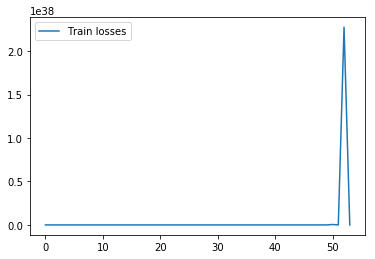

In [8]:
data = np.loadtxt('./data/20news-bydate/matlab/train.data')
labels = np.loadtxt('./data/20news-bydate/matlab/train.label')
labels -= 1
data = restructure_data(data)
data = standardize_data(data)
Vocab_size = data.shape[1]

train_loader,_= make_loaders(data,labels,1,batch_size=1)
var_model = MLP_20(Vocab_size,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.2,momentum=0.9)
loss_func = nn.NLLLoss()
model, losses = train_5000(var_model,train_loader,optimizer,loss_func)


Iteration: 1 Loss: 4.230446815490723
Iteration: 2 Loss: nan
Iteration: 3 Loss: nan
Iteration: 4 Loss: nan
Iteration: 5 Loss: nan
Iteration: 6 Loss: nan
Iteration: 7 Loss: nan
Iteration: 8 Loss: nan
Iteration: 9 Loss: nan
Iteration: 10 Loss: nan
Iteration: 11 Loss: nan
Iteration: 12 Loss: nan
Iteration: 13 Loss: nan
Iteration: 14 Loss: nan
Iteration: 15 Loss: nan
Iteration: 16 Loss: nan
Iteration: 17 Loss: nan
Iteration: 18 Loss: nan
Iteration: 19 Loss: nan
Iteration: 20 Loss: nan
Iteration: 21 Loss: nan
Iteration: 22 Loss: nan
Iteration: 23 Loss: nan
Iteration: 24 Loss: nan
Iteration: 25 Loss: nan
Iteration: 26 Loss: nan
Iteration: 27 Loss: nan
Iteration: 28 Loss: nan
Iteration: 29 Loss: nan
Iteration: 30 Loss: nan
Iteration: 31 Loss: nan
Iteration: 32 Loss: nan
Iteration: 33 Loss: nan
Iteration: 34 Loss: nan
Iteration: 35 Loss: nan
Iteration: 36 Loss: nan
Iteration: 37 Loss: nan
Iteration: 38 Loss: nan
Iteration: 39 Loss: nan
Iteration: 40 Loss: nan
Iteration: 41 Loss: nan
Iteration: 

Iteration: 333 Loss: nan
Iteration: 334 Loss: nan
Iteration: 335 Loss: nan
Iteration: 336 Loss: nan
Iteration: 337 Loss: nan
Iteration: 338 Loss: nan
Iteration: 339 Loss: nan
Iteration: 340 Loss: nan
Iteration: 341 Loss: nan
Iteration: 342 Loss: nan
Iteration: 343 Loss: nan
Iteration: 344 Loss: nan
Iteration: 345 Loss: nan
Iteration: 346 Loss: nan
Iteration: 347 Loss: nan
Iteration: 348 Loss: nan
Iteration: 349 Loss: nan
Iteration: 350 Loss: nan
Iteration: 351 Loss: nan
Iteration: 352 Loss: nan
Iteration: 353 Loss: nan
Iteration: 354 Loss: nan
Iteration: 355 Loss: nan
Iteration: 356 Loss: nan
Iteration: 357 Loss: nan
Iteration: 358 Loss: nan
Iteration: 359 Loss: nan
Iteration: 360 Loss: nan
Iteration: 361 Loss: nan
Iteration: 362 Loss: nan
Iteration: 363 Loss: nan
Iteration: 364 Loss: nan
Iteration: 365 Loss: nan
Iteration: 366 Loss: nan
Iteration: 367 Loss: nan
Iteration: 368 Loss: nan
Iteration: 369 Loss: nan
Iteration: 370 Loss: nan
Iteration: 371 Loss: nan
Iteration: 372 Loss: nan


Iteration: 662 Loss: nan
Iteration: 663 Loss: nan
Iteration: 664 Loss: nan
Iteration: 665 Loss: nan
Iteration: 666 Loss: nan
Iteration: 667 Loss: nan
Iteration: 668 Loss: nan
Iteration: 669 Loss: nan
Iteration: 670 Loss: nan
Iteration: 671 Loss: nan
Iteration: 672 Loss: nan
Iteration: 673 Loss: nan
Iteration: 674 Loss: nan
Iteration: 675 Loss: nan
Iteration: 676 Loss: nan
Iteration: 677 Loss: nan
Iteration: 678 Loss: nan
Iteration: 679 Loss: nan
Iteration: 680 Loss: nan
Iteration: 681 Loss: nan
Iteration: 682 Loss: nan
Iteration: 683 Loss: nan
Iteration: 684 Loss: nan
Iteration: 685 Loss: nan
Iteration: 686 Loss: nan
Iteration: 687 Loss: nan
Iteration: 688 Loss: nan
Iteration: 689 Loss: nan
Iteration: 690 Loss: nan
Iteration: 691 Loss: nan
Iteration: 692 Loss: nan
Iteration: 693 Loss: nan
Iteration: 694 Loss: nan
Iteration: 695 Loss: nan
Iteration: 696 Loss: nan
Iteration: 697 Loss: nan
Iteration: 698 Loss: nan
Iteration: 699 Loss: nan
Iteration: 700 Loss: nan
Iteration: 701 Loss: nan


Iteration: 998 Loss: nan
Iteration: 999 Loss: nan
Iteration: 1000 Loss: nan
Iteration: 1001 Loss: nan
Iteration: 1002 Loss: nan
Iteration: 1003 Loss: nan
Iteration: 1004 Loss: nan
Iteration: 1005 Loss: nan
Iteration: 1006 Loss: nan
Iteration: 1007 Loss: nan
Iteration: 1008 Loss: nan
Iteration: 1009 Loss: nan
Iteration: 1010 Loss: nan
Iteration: 1011 Loss: nan
Iteration: 1012 Loss: nan
Iteration: 1013 Loss: nan
Iteration: 1014 Loss: nan
Iteration: 1015 Loss: nan
Iteration: 1016 Loss: nan
Iteration: 1017 Loss: nan
Iteration: 1018 Loss: nan
Iteration: 1019 Loss: nan
Iteration: 1020 Loss: nan
Iteration: 1021 Loss: nan
Iteration: 1022 Loss: nan
Iteration: 1023 Loss: nan
Iteration: 1024 Loss: nan
Iteration: 1025 Loss: nan
Iteration: 1026 Loss: nan
Iteration: 1027 Loss: nan
Iteration: 1028 Loss: nan
Iteration: 1029 Loss: nan
Iteration: 1030 Loss: nan
Iteration: 1031 Loss: nan
Iteration: 1032 Loss: nan
Iteration: 1033 Loss: nan
Iteration: 1034 Loss: nan
Iteration: 1035 Loss: nan
Iteration: 103

Iteration: 1319 Loss: nan
Iteration: 1320 Loss: nan
Iteration: 1321 Loss: nan
Iteration: 1322 Loss: nan
Iteration: 1323 Loss: nan
Iteration: 1324 Loss: nan
Iteration: 1325 Loss: nan
Iteration: 1326 Loss: nan
Iteration: 1327 Loss: nan
Iteration: 1328 Loss: nan
Iteration: 1329 Loss: nan
Iteration: 1330 Loss: nan
Iteration: 1331 Loss: nan
Iteration: 1332 Loss: nan
Iteration: 1333 Loss: nan
Iteration: 1334 Loss: nan
Iteration: 1335 Loss: nan
Iteration: 1336 Loss: nan
Iteration: 1337 Loss: nan
Iteration: 1338 Loss: nan
Iteration: 1339 Loss: nan
Iteration: 1340 Loss: nan
Iteration: 1341 Loss: nan
Iteration: 1342 Loss: nan
Iteration: 1343 Loss: nan
Iteration: 1344 Loss: nan
Iteration: 1345 Loss: nan
Iteration: 1346 Loss: nan
Iteration: 1347 Loss: nan
Iteration: 1348 Loss: nan
Iteration: 1349 Loss: nan
Iteration: 1350 Loss: nan
Iteration: 1351 Loss: nan
Iteration: 1352 Loss: nan
Iteration: 1353 Loss: nan
Iteration: 1354 Loss: nan
Iteration: 1355 Loss: nan
Iteration: 1356 Loss: nan
Iteration: 1

Iteration: 1639 Loss: nan
Iteration: 1640 Loss: nan
Iteration: 1641 Loss: nan
Iteration: 1642 Loss: nan
Iteration: 1643 Loss: nan
Iteration: 1644 Loss: nan
Iteration: 1645 Loss: nan
Iteration: 1646 Loss: nan
Iteration: 1647 Loss: nan
Iteration: 1648 Loss: nan
Iteration: 1649 Loss: nan
Iteration: 1650 Loss: nan
Iteration: 1651 Loss: nan
Iteration: 1652 Loss: nan
Iteration: 1653 Loss: nan
Iteration: 1654 Loss: nan
Iteration: 1655 Loss: nan
Iteration: 1656 Loss: nan
Iteration: 1657 Loss: nan
Iteration: 1658 Loss: nan
Iteration: 1659 Loss: nan
Iteration: 1660 Loss: nan
Iteration: 1661 Loss: nan
Iteration: 1662 Loss: nan
Iteration: 1663 Loss: nan
Iteration: 1664 Loss: nan
Iteration: 1665 Loss: nan
Iteration: 1666 Loss: nan
Iteration: 1667 Loss: nan
Iteration: 1668 Loss: nan
Iteration: 1669 Loss: nan
Iteration: 1670 Loss: nan
Iteration: 1671 Loss: nan
Iteration: 1672 Loss: nan
Iteration: 1673 Loss: nan
Iteration: 1674 Loss: nan
Iteration: 1675 Loss: nan
Iteration: 1676 Loss: nan
Iteration: 1

Iteration: 1955 Loss: nan
Iteration: 1956 Loss: nan
Iteration: 1957 Loss: nan
Iteration: 1958 Loss: nan
Iteration: 1959 Loss: nan
Iteration: 1960 Loss: nan
Iteration: 1961 Loss: nan
Iteration: 1962 Loss: nan
Iteration: 1963 Loss: nan
Iteration: 1964 Loss: nan
Iteration: 1965 Loss: nan
Iteration: 1966 Loss: nan
Iteration: 1967 Loss: nan
Iteration: 1968 Loss: nan
Iteration: 1969 Loss: nan
Iteration: 1970 Loss: nan
Iteration: 1971 Loss: nan
Iteration: 1972 Loss: nan
Iteration: 1973 Loss: nan
Iteration: 1974 Loss: nan
Iteration: 1975 Loss: nan
Iteration: 1976 Loss: nan
Iteration: 1977 Loss: nan
Iteration: 1978 Loss: nan
Iteration: 1979 Loss: nan
Iteration: 1980 Loss: nan
Iteration: 1981 Loss: nan
Iteration: 1982 Loss: nan
Iteration: 1983 Loss: nan
Iteration: 1984 Loss: nan
Iteration: 1985 Loss: nan
Iteration: 1986 Loss: nan
Iteration: 1987 Loss: nan
Iteration: 1988 Loss: nan
Iteration: 1989 Loss: nan
Iteration: 1990 Loss: nan
Iteration: 1991 Loss: nan
Iteration: 1992 Loss: nan
Iteration: 1

Iteration: 2275 Loss: nan
Iteration: 2276 Loss: nan
Iteration: 2277 Loss: nan
Iteration: 2278 Loss: nan
Iteration: 2279 Loss: nan
Iteration: 2280 Loss: nan
Iteration: 2281 Loss: nan
Iteration: 2282 Loss: nan
Iteration: 2283 Loss: nan
Iteration: 2284 Loss: nan
Iteration: 2285 Loss: nan
Iteration: 2286 Loss: nan
Iteration: 2287 Loss: nan
Iteration: 2288 Loss: nan
Iteration: 2289 Loss: nan
Iteration: 2290 Loss: nan
Iteration: 2291 Loss: nan
Iteration: 2292 Loss: nan
Iteration: 2293 Loss: nan
Iteration: 2294 Loss: nan
Iteration: 2295 Loss: nan
Iteration: 2296 Loss: nan
Iteration: 2297 Loss: nan
Iteration: 2298 Loss: nan
Iteration: 2299 Loss: nan
Iteration: 2300 Loss: nan
Iteration: 2301 Loss: nan
Iteration: 2302 Loss: nan
Iteration: 2303 Loss: nan
Iteration: 2304 Loss: nan
Iteration: 2305 Loss: nan
Iteration: 2306 Loss: nan
Iteration: 2307 Loss: nan
Iteration: 2308 Loss: nan
Iteration: 2309 Loss: nan
Iteration: 2310 Loss: nan
Iteration: 2311 Loss: nan
Iteration: 2312 Loss: nan
Iteration: 2

Iteration: 2603 Loss: nan
Iteration: 2604 Loss: nan
Iteration: 2605 Loss: nan
Iteration: 2606 Loss: nan
Iteration: 2607 Loss: nan
Iteration: 2608 Loss: nan
Iteration: 2609 Loss: nan
Iteration: 2610 Loss: nan
Iteration: 2611 Loss: nan
Iteration: 2612 Loss: nan
Iteration: 2613 Loss: nan
Iteration: 2614 Loss: nan
Iteration: 2615 Loss: nan
Iteration: 2616 Loss: nan
Iteration: 2617 Loss: nan
Iteration: 2618 Loss: nan
Iteration: 2619 Loss: nan
Iteration: 2620 Loss: nan
Iteration: 2621 Loss: nan
Iteration: 2622 Loss: nan
Iteration: 2623 Loss: nan
Iteration: 2624 Loss: nan
Iteration: 2625 Loss: nan
Iteration: 2626 Loss: nan
Iteration: 2627 Loss: nan
Iteration: 2628 Loss: nan
Iteration: 2629 Loss: nan
Iteration: 2630 Loss: nan
Iteration: 2631 Loss: nan
Iteration: 2632 Loss: nan
Iteration: 2633 Loss: nan
Iteration: 2634 Loss: nan
Iteration: 2635 Loss: nan
Iteration: 2636 Loss: nan
Iteration: 2637 Loss: nan
Iteration: 2638 Loss: nan
Iteration: 2639 Loss: nan
Iteration: 2640 Loss: nan
Iteration: 2

Iteration: 2920 Loss: nan
Iteration: 2921 Loss: nan
Iteration: 2922 Loss: nan
Iteration: 2923 Loss: nan
Iteration: 2924 Loss: nan
Iteration: 2925 Loss: nan
Iteration: 2926 Loss: nan
Iteration: 2927 Loss: nan
Iteration: 2928 Loss: nan
Iteration: 2929 Loss: nan
Iteration: 2930 Loss: nan
Iteration: 2931 Loss: nan
Iteration: 2932 Loss: nan
Iteration: 2933 Loss: nan
Iteration: 2934 Loss: nan
Iteration: 2935 Loss: nan
Iteration: 2936 Loss: nan
Iteration: 2937 Loss: nan
Iteration: 2938 Loss: nan
Iteration: 2939 Loss: nan
Iteration: 2940 Loss: nan
Iteration: 2941 Loss: nan
Iteration: 2942 Loss: nan
Iteration: 2943 Loss: nan
Iteration: 2944 Loss: nan
Iteration: 2945 Loss: nan
Iteration: 2946 Loss: nan
Iteration: 2947 Loss: nan
Iteration: 2948 Loss: nan
Iteration: 2949 Loss: nan
Iteration: 2950 Loss: nan
Iteration: 2951 Loss: nan
Iteration: 2952 Loss: nan
Iteration: 2953 Loss: nan
Iteration: 2954 Loss: nan
Iteration: 2955 Loss: nan
Iteration: 2956 Loss: nan
Iteration: 2957 Loss: nan
Iteration: 2

Iteration: 3239 Loss: nan
Iteration: 3240 Loss: nan
Iteration: 3241 Loss: nan
Iteration: 3242 Loss: nan
Iteration: 3243 Loss: nan
Iteration: 3244 Loss: nan
Iteration: 3245 Loss: nan
Iteration: 3246 Loss: nan
Iteration: 3247 Loss: nan
Iteration: 3248 Loss: nan
Iteration: 3249 Loss: nan
Iteration: 3250 Loss: nan
Iteration: 3251 Loss: nan
Iteration: 3252 Loss: nan
Iteration: 3253 Loss: nan
Iteration: 3254 Loss: nan
Iteration: 3255 Loss: nan
Iteration: 3256 Loss: nan
Iteration: 3257 Loss: nan
Iteration: 3258 Loss: nan
Iteration: 3259 Loss: nan
Iteration: 3260 Loss: nan
Iteration: 3261 Loss: nan
Iteration: 3262 Loss: nan
Iteration: 3263 Loss: nan
Iteration: 3264 Loss: nan
Iteration: 3265 Loss: nan
Iteration: 3266 Loss: nan
Iteration: 3267 Loss: nan
Iteration: 3268 Loss: nan
Iteration: 3269 Loss: nan
Iteration: 3270 Loss: nan
Iteration: 3271 Loss: nan
Iteration: 3272 Loss: nan
Iteration: 3273 Loss: nan
Iteration: 3274 Loss: nan
Iteration: 3275 Loss: nan
Iteration: 3276 Loss: nan
Iteration: 3

Iteration: 3557 Loss: nan
Iteration: 3558 Loss: nan
Iteration: 3559 Loss: nan
Iteration: 3560 Loss: nan
Iteration: 3561 Loss: nan
Iteration: 3562 Loss: nan
Iteration: 3563 Loss: nan
Iteration: 3564 Loss: nan
Iteration: 3565 Loss: nan
Iteration: 3566 Loss: nan
Iteration: 3567 Loss: nan
Iteration: 3568 Loss: nan
Iteration: 3569 Loss: nan
Iteration: 3570 Loss: nan
Iteration: 3571 Loss: nan
Iteration: 3572 Loss: nan
Iteration: 3573 Loss: nan
Iteration: 3574 Loss: nan
Iteration: 3575 Loss: nan
Iteration: 3576 Loss: nan
Iteration: 3577 Loss: nan
Iteration: 3578 Loss: nan
Iteration: 3579 Loss: nan
Iteration: 3580 Loss: nan
Iteration: 3581 Loss: nan
Iteration: 3582 Loss: nan
Iteration: 3583 Loss: nan
Iteration: 3584 Loss: nan
Iteration: 3585 Loss: nan
Iteration: 3586 Loss: nan
Iteration: 3587 Loss: nan
Iteration: 3588 Loss: nan
Iteration: 3589 Loss: nan
Iteration: 3590 Loss: nan
Iteration: 3591 Loss: nan
Iteration: 3592 Loss: nan
Iteration: 3593 Loss: nan
Iteration: 3594 Loss: nan
Iteration: 3

Iteration: 3885 Loss: nan
Iteration: 3886 Loss: nan
Iteration: 3887 Loss: nan
Iteration: 3888 Loss: nan
Iteration: 3889 Loss: nan
Iteration: 3890 Loss: nan
Iteration: 3891 Loss: nan
Iteration: 3892 Loss: nan
Iteration: 3893 Loss: nan
Iteration: 3894 Loss: nan
Iteration: 3895 Loss: nan
Iteration: 3896 Loss: nan
Iteration: 3897 Loss: nan
Iteration: 3898 Loss: nan
Iteration: 3899 Loss: nan
Iteration: 3900 Loss: nan
Iteration: 3901 Loss: nan
Iteration: 3902 Loss: nan
Iteration: 3903 Loss: nan
Iteration: 3904 Loss: nan
Iteration: 3905 Loss: nan
Iteration: 3906 Loss: nan
Iteration: 3907 Loss: nan
Iteration: 3908 Loss: nan
Iteration: 3909 Loss: nan
Iteration: 3910 Loss: nan
Iteration: 3911 Loss: nan
Iteration: 3912 Loss: nan
Iteration: 3913 Loss: nan
Iteration: 3914 Loss: nan
Iteration: 3915 Loss: nan
Iteration: 3916 Loss: nan
Iteration: 3917 Loss: nan
Iteration: 3918 Loss: nan
Iteration: 3919 Loss: nan
Iteration: 3920 Loss: nan
Iteration: 3921 Loss: nan
Iteration: 3922 Loss: nan
Iteration: 3

Iteration: 4211 Loss: nan
Iteration: 4212 Loss: nan
Iteration: 4213 Loss: nan
Iteration: 4214 Loss: nan
Iteration: 4215 Loss: nan
Iteration: 4216 Loss: nan
Iteration: 4217 Loss: nan
Iteration: 4218 Loss: nan
Iteration: 4219 Loss: nan
Iteration: 4220 Loss: nan
Iteration: 4221 Loss: nan
Iteration: 4222 Loss: nan
Iteration: 4223 Loss: nan
Iteration: 4224 Loss: nan
Iteration: 4225 Loss: nan
Iteration: 4226 Loss: nan
Iteration: 4227 Loss: nan
Iteration: 4228 Loss: nan
Iteration: 4229 Loss: nan
Iteration: 4230 Loss: nan
Iteration: 4231 Loss: nan
Iteration: 4232 Loss: nan
Iteration: 4233 Loss: nan
Iteration: 4234 Loss: nan
Iteration: 4235 Loss: nan
Iteration: 4236 Loss: nan
Iteration: 4237 Loss: nan
Iteration: 4238 Loss: nan
Iteration: 4239 Loss: nan
Iteration: 4240 Loss: nan
Iteration: 4241 Loss: nan
Iteration: 4242 Loss: nan
Iteration: 4243 Loss: nan
Iteration: 4244 Loss: nan
Iteration: 4245 Loss: nan
Iteration: 4246 Loss: nan
Iteration: 4247 Loss: nan
Iteration: 4248 Loss: nan
Iteration: 4

Iteration: 4537 Loss: nan
Iteration: 4538 Loss: nan
Iteration: 4539 Loss: nan
Iteration: 4540 Loss: nan
Iteration: 4541 Loss: nan
Iteration: 4542 Loss: nan
Iteration: 4543 Loss: nan
Iteration: 4544 Loss: nan
Iteration: 4545 Loss: nan
Iteration: 4546 Loss: nan
Iteration: 4547 Loss: nan
Iteration: 4548 Loss: nan
Iteration: 4549 Loss: nan
Iteration: 4550 Loss: nan
Iteration: 4551 Loss: nan
Iteration: 4552 Loss: nan
Iteration: 4553 Loss: nan
Iteration: 4554 Loss: nan
Iteration: 4555 Loss: nan
Iteration: 4556 Loss: nan
Iteration: 4557 Loss: nan
Iteration: 4558 Loss: nan
Iteration: 4559 Loss: nan
Iteration: 4560 Loss: nan
Iteration: 4561 Loss: nan
Iteration: 4562 Loss: nan
Iteration: 4563 Loss: nan
Iteration: 4564 Loss: nan
Iteration: 4565 Loss: nan
Iteration: 4566 Loss: nan
Iteration: 4567 Loss: nan
Iteration: 4568 Loss: nan
Iteration: 4569 Loss: nan
Iteration: 4570 Loss: nan
Iteration: 4571 Loss: nan
Iteration: 4572 Loss: nan
Iteration: 4573 Loss: nan
Iteration: 4574 Loss: nan
Iteration: 4

Iteration: 4864 Loss: nan
Iteration: 4865 Loss: nan
Iteration: 4866 Loss: nan
Iteration: 4867 Loss: nan
Iteration: 4868 Loss: nan
Iteration: 4869 Loss: nan
Iteration: 4870 Loss: nan
Iteration: 4871 Loss: nan
Iteration: 4872 Loss: nan
Iteration: 4873 Loss: nan
Iteration: 4874 Loss: nan
Iteration: 4875 Loss: nan
Iteration: 4876 Loss: nan
Iteration: 4877 Loss: nan
Iteration: 4878 Loss: nan
Iteration: 4879 Loss: nan
Iteration: 4880 Loss: nan
Iteration: 4881 Loss: nan
Iteration: 4882 Loss: nan
Iteration: 4883 Loss: nan
Iteration: 4884 Loss: nan
Iteration: 4885 Loss: nan
Iteration: 4886 Loss: nan
Iteration: 4887 Loss: nan
Iteration: 4888 Loss: nan
Iteration: 4889 Loss: nan
Iteration: 4890 Loss: nan
Iteration: 4891 Loss: nan
Iteration: 4892 Loss: nan
Iteration: 4893 Loss: nan
Iteration: 4894 Loss: nan
Iteration: 4895 Loss: nan
Iteration: 4896 Loss: nan
Iteration: 4897 Loss: nan
Iteration: 4898 Loss: nan
Iteration: 4899 Loss: nan
Iteration: 4900 Loss: nan
Iteration: 4901 Loss: nan
Iteration: 4

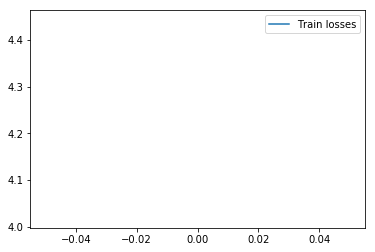

In [11]:
model, losses = train_5000(var_model,train_loader,optimizer,loss_func)

In [14]:
train_loader,_= make_loaders(data,labels,1,batch_size=100)
var_model = MLP_20(Vocab_size,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.2)
loss_func = nn.nn.CrossEntropyLoss()
model, losses = train_5000(var_model,train_loader,optimizer,loss_func)

(11269, 53975) (11269,)
(0, 53975) (0,)
Iteration: 1 Loss: 0.3622467517852783
Iteration: 2 Loss: -1.376916766166687
Iteration: 3 Loss: -3.7766125202178955
Iteration: 4 Loss: -13.707437515258789
Iteration: 5 Loss: -27.997180938720703
Iteration: 6 Loss: -41.2104606628418
Iteration: 7 Loss: -130.37808227539062
Iteration: 8 Loss: -385.4134521484375
Iteration: 9 Loss: -529.7797241210938
Iteration: 10 Loss: -1071.483154296875
Iteration: 11 Loss: -1781.5927734375
Iteration: 12 Loss: -6194.84423828125
Iteration: 13 Loss: -12807.44140625
Iteration: 14 Loss: -23499.001953125
Iteration: 15 Loss: -42617.26953125
Iteration: 16 Loss: -100649.3828125
Iteration: 17 Loss: -240658.921875
Iteration: 18 Loss: -317381.875
Iteration: 19 Loss: -1145876.25
Iteration: 20 Loss: -1861345.125
Iteration: 21 Loss: -3135172.75
Iteration: 22 Loss: -12349751.0
Iteration: 23 Loss: -18653986.0
Iteration: 24 Loss: -78752816.0
Iteration: 25 Loss: -109641760.0
Iteration: 26 Loss: -280338368.0
Iteration: 27 Loss: -705534592

Iteration: 267 Loss: nan
Iteration: 268 Loss: nan
Iteration: 269 Loss: nan
Iteration: 270 Loss: nan
Iteration: 271 Loss: nan
Iteration: 272 Loss: nan
Iteration: 273 Loss: nan
Iteration: 274 Loss: nan
Iteration: 275 Loss: nan
Iteration: 276 Loss: nan
Iteration: 277 Loss: nan
Iteration: 278 Loss: nan
Iteration: 279 Loss: nan
Iteration: 280 Loss: nan
Iteration: 281 Loss: nan
Iteration: 282 Loss: nan
Iteration: 283 Loss: nan
Iteration: 284 Loss: nan
Iteration: 285 Loss: nan
Iteration: 286 Loss: nan
Iteration: 287 Loss: nan
Iteration: 288 Loss: nan
Iteration: 289 Loss: nan
Iteration: 290 Loss: nan
Iteration: 291 Loss: nan
Iteration: 292 Loss: nan
Iteration: 293 Loss: nan
Iteration: 294 Loss: nan
Iteration: 295 Loss: nan
Iteration: 296 Loss: nan
Iteration: 297 Loss: nan
Iteration: 298 Loss: nan
Iteration: 299 Loss: nan
Iteration: 300 Loss: nan
Iteration: 301 Loss: nan
Iteration: 302 Loss: nan
Iteration: 303 Loss: nan
Iteration: 304 Loss: nan
Iteration: 305 Loss: nan
Iteration: 306 Loss: nan


Iteration: 597 Loss: nan
Iteration: 598 Loss: nan
Iteration: 599 Loss: nan
Iteration: 600 Loss: nan
Iteration: 601 Loss: nan
Iteration: 602 Loss: nan
Iteration: 603 Loss: nan
Iteration: 604 Loss: nan
Iteration: 605 Loss: nan
Iteration: 606 Loss: nan
Iteration: 607 Loss: nan
Iteration: 608 Loss: nan
Iteration: 609 Loss: nan
Iteration: 610 Loss: nan
Iteration: 611 Loss: nan
Iteration: 612 Loss: nan
Iteration: 613 Loss: nan
Iteration: 614 Loss: nan
Iteration: 615 Loss: nan
Iteration: 616 Loss: nan
Iteration: 617 Loss: nan
Iteration: 618 Loss: nan
Iteration: 619 Loss: nan
Iteration: 620 Loss: nan
Iteration: 621 Loss: nan
Iteration: 622 Loss: nan
Iteration: 623 Loss: nan
Iteration: 624 Loss: nan
Iteration: 625 Loss: nan
Iteration: 626 Loss: nan
Iteration: 627 Loss: nan
Iteration: 628 Loss: nan
Iteration: 629 Loss: nan
Iteration: 630 Loss: nan
Iteration: 631 Loss: nan
Iteration: 632 Loss: nan
Iteration: 633 Loss: nan
Iteration: 634 Loss: nan
Iteration: 635 Loss: nan
Iteration: 636 Loss: nan


Iteration: 927 Loss: nan
Iteration: 928 Loss: nan
Iteration: 929 Loss: nan
Iteration: 930 Loss: nan
Iteration: 931 Loss: nan
Iteration: 932 Loss: nan
Iteration: 933 Loss: nan
Iteration: 934 Loss: nan
Iteration: 935 Loss: nan
Iteration: 936 Loss: nan
Iteration: 937 Loss: nan
Iteration: 938 Loss: nan
Iteration: 939 Loss: nan
Iteration: 940 Loss: nan
Iteration: 941 Loss: nan
Iteration: 942 Loss: nan
Iteration: 943 Loss: nan
Iteration: 944 Loss: nan
Iteration: 945 Loss: nan
Iteration: 946 Loss: nan
Iteration: 947 Loss: nan
Iteration: 948 Loss: nan
Iteration: 949 Loss: nan
Iteration: 950 Loss: nan
Iteration: 951 Loss: nan
Iteration: 952 Loss: nan
Iteration: 953 Loss: nan
Iteration: 954 Loss: nan
Iteration: 955 Loss: nan
Iteration: 956 Loss: nan
Iteration: 957 Loss: nan
Iteration: 958 Loss: nan
Iteration: 959 Loss: nan
Iteration: 960 Loss: nan
Iteration: 961 Loss: nan
Iteration: 962 Loss: nan
Iteration: 963 Loss: nan
Iteration: 964 Loss: nan
Iteration: 965 Loss: nan
Iteration: 966 Loss: nan


TypeError: 'NoneType' object is not iterable

Iteration: 1 Loss: 3.5393199920654297
Iteration: 2 Loss: 3.1645619869232178
Iteration: 3 Loss: 3.7164053916931152
Iteration: 4 Loss: 2.6979188919067383
Iteration: 5 Loss: 3.9454195499420166
Iteration: 6 Loss: 6.8036112785339355
Iteration: 7 Loss: 6.061787128448486
Iteration: 8 Loss: 5.183966636657715
Iteration: 9 Loss: 7.287364482879639
Iteration: 10 Loss: 5.195305824279785
Iteration: 11 Loss: 12.733965873718262
Iteration: 12 Loss: 15.7228422164917
Iteration: 13 Loss: 24.353858947753906
Iteration: 14 Loss: 89.57996368408203
Iteration: 15 Loss: 74.3738021850586
Iteration: 16 Loss: 128.15689086914062
Iteration: 17 Loss: 208.1860809326172
Iteration: 18 Loss: 181.68707275390625
Iteration: 19 Loss: 182.86265563964844
Iteration: 20 Loss: 380.988525390625
Iteration: 21 Loss: 386.5858154296875
Iteration: 22 Loss: 775.0795288085938
Iteration: 23 Loss: 532.1685791015625
Iteration: 24 Loss: 897.8995361328125
Iteration: 25 Loss: 981.4090576171875
Iteration: 26 Loss: 2118.31884765625
Iteration: 27 

Iteration: 213 Loss: 3.2535609746625574e+32
Iteration: 214 Loss: 7.596324266602881e+32
Iteration: 215 Loss: 7.636444355851071e+32
Iteration: 216 Loss: 9.751330286990871e+32
Iteration: 217 Loss: 1.8786550946881378e+33
Iteration: 218 Loss: 3.997609206282039e+33
Iteration: 219 Loss: 3.740035045613058e+33
Iteration: 220 Loss: 9.361777946051131e+33
Iteration: 221 Loss: 1.3358732282052389e+34
Iteration: 222 Loss: 1.74036109907945e+34
Iteration: 223 Loss: 2.9791301868091398e+34
Iteration: 224 Loss: 3.253365596775857e+34
Iteration: 225 Loss: 3.4429212038833053e+34
Iteration: 226 Loss: 7.206075213009031e+34
Iteration: 227 Loss: 1.3000381817472324e+35
Iteration: 228 Loss: 1.4969897873429887e+35
Iteration: 229 Loss: 2.0061517525153776e+35
Iteration: 230 Loss: 3.803453711094216e+35
Iteration: 231 Loss: 4.95851713098155e+35
Iteration: 232 Loss: 8.716401972124062e+35
Iteration: 233 Loss: 1.0869184057990277e+36
Iteration: 234 Loss: 1.647861639988108e+36
Iteration: 235 Loss: 1.1803281717188578e+36
Ite

Iteration: 528 Loss: nan
Iteration: 529 Loss: nan
Iteration: 530 Loss: nan
Iteration: 531 Loss: nan
Iteration: 532 Loss: nan
Iteration: 533 Loss: nan
Iteration: 534 Loss: nan
Iteration: 535 Loss: nan
Iteration: 536 Loss: nan
Iteration: 537 Loss: nan
Iteration: 538 Loss: nan
Iteration: 539 Loss: nan
Iteration: 540 Loss: nan
Iteration: 541 Loss: nan
Iteration: 542 Loss: nan
Iteration: 543 Loss: nan
Iteration: 544 Loss: nan
Iteration: 545 Loss: nan
Iteration: 546 Loss: nan
Iteration: 547 Loss: nan
Iteration: 548 Loss: nan
Iteration: 549 Loss: nan
Iteration: 550 Loss: nan
Iteration: 551 Loss: nan
Iteration: 552 Loss: nan
Iteration: 553 Loss: nan
Iteration: 554 Loss: nan
Iteration: 555 Loss: nan
Iteration: 556 Loss: nan
Iteration: 557 Loss: nan
Iteration: 558 Loss: nan
Iteration: 559 Loss: nan
Iteration: 560 Loss: nan
Iteration: 561 Loss: nan
Iteration: 562 Loss: nan
Iteration: 563 Loss: nan
Iteration: 564 Loss: nan
Iteration: 565 Loss: nan
Iteration: 566 Loss: nan
Iteration: 567 Loss: nan


Iteration: 856 Loss: nan
Iteration: 857 Loss: nan
Iteration: 858 Loss: nan
Iteration: 859 Loss: nan
Iteration: 860 Loss: nan
Iteration: 861 Loss: nan
Iteration: 862 Loss: nan
Iteration: 863 Loss: nan
Iteration: 864 Loss: nan
Iteration: 865 Loss: nan
Iteration: 866 Loss: nan
Iteration: 867 Loss: nan
Iteration: 868 Loss: nan
Iteration: 869 Loss: nan
Iteration: 870 Loss: nan
Iteration: 871 Loss: nan
Iteration: 872 Loss: nan
Iteration: 873 Loss: nan
Iteration: 874 Loss: nan
Iteration: 875 Loss: nan
Iteration: 876 Loss: nan
Iteration: 877 Loss: nan
Iteration: 878 Loss: nan
Iteration: 879 Loss: nan
Iteration: 880 Loss: nan
Iteration: 881 Loss: nan
Iteration: 882 Loss: nan
Iteration: 883 Loss: nan
Iteration: 884 Loss: nan
Iteration: 885 Loss: nan
Iteration: 886 Loss: nan
Iteration: 887 Loss: nan
Iteration: 888 Loss: nan
Iteration: 889 Loss: nan
Iteration: 890 Loss: nan
Iteration: 891 Loss: nan
Iteration: 892 Loss: nan
Iteration: 893 Loss: nan
Iteration: 894 Loss: nan
Iteration: 895 Loss: nan


Iteration: 1177 Loss: nan
Iteration: 1178 Loss: nan
Iteration: 1179 Loss: nan
Iteration: 1180 Loss: nan
Iteration: 1181 Loss: nan
Iteration: 1182 Loss: nan
Iteration: 1183 Loss: nan
Iteration: 1184 Loss: nan
Iteration: 1185 Loss: nan
Iteration: 1186 Loss: nan
Iteration: 1187 Loss: nan
Iteration: 1188 Loss: nan
Iteration: 1189 Loss: nan
Iteration: 1190 Loss: nan
Iteration: 1191 Loss: nan
Iteration: 1192 Loss: nan
Iteration: 1193 Loss: nan
Iteration: 1194 Loss: nan
Iteration: 1195 Loss: nan
Iteration: 1196 Loss: nan
Iteration: 1197 Loss: nan
Iteration: 1198 Loss: nan
Iteration: 1199 Loss: nan
Iteration: 1200 Loss: nan
Iteration: 1201 Loss: nan
Iteration: 1202 Loss: nan
Iteration: 1203 Loss: nan
Iteration: 1204 Loss: nan
Iteration: 1205 Loss: nan
Iteration: 1206 Loss: nan
Iteration: 1207 Loss: nan
Iteration: 1208 Loss: nan
Iteration: 1209 Loss: nan
Iteration: 1210 Loss: nan
Iteration: 1211 Loss: nan
Iteration: 1212 Loss: nan
Iteration: 1213 Loss: nan
Iteration: 1214 Loss: nan
Iteration: 1

Iteration: 1495 Loss: nan
Iteration: 1496 Loss: nan
Iteration: 1497 Loss: nan
Iteration: 1498 Loss: nan
Iteration: 1499 Loss: nan
Iteration: 1500 Loss: nan
Iteration: 1501 Loss: nan
Iteration: 1502 Loss: nan
Iteration: 1503 Loss: nan
Iteration: 1504 Loss: nan
Iteration: 1505 Loss: nan
Iteration: 1506 Loss: nan
Iteration: 1507 Loss: nan
Iteration: 1508 Loss: nan
Iteration: 1509 Loss: nan
Iteration: 1510 Loss: nan
Iteration: 1511 Loss: nan
Iteration: 1512 Loss: nan
Iteration: 1513 Loss: nan
Iteration: 1514 Loss: nan
Iteration: 1515 Loss: nan
Iteration: 1516 Loss: nan
Iteration: 1517 Loss: nan
Iteration: 1518 Loss: nan
Iteration: 1519 Loss: nan
Iteration: 1520 Loss: nan
Iteration: 1521 Loss: nan
Iteration: 1522 Loss: nan
Iteration: 1523 Loss: nan
Iteration: 1524 Loss: nan
Iteration: 1525 Loss: nan
Iteration: 1526 Loss: nan
Iteration: 1527 Loss: nan
Iteration: 1528 Loss: nan
Iteration: 1529 Loss: nan
Iteration: 1530 Loss: nan
Iteration: 1531 Loss: nan
Iteration: 1532 Loss: nan
Iteration: 1

Iteration: 1815 Loss: nan
Iteration: 1816 Loss: nan
Iteration: 1817 Loss: nan
Iteration: 1818 Loss: nan
Iteration: 1819 Loss: nan
Iteration: 1820 Loss: nan
Iteration: 1821 Loss: nan
Iteration: 1822 Loss: nan
Iteration: 1823 Loss: nan
Iteration: 1824 Loss: nan
Iteration: 1825 Loss: nan
Iteration: 1826 Loss: nan
Iteration: 1827 Loss: nan
Iteration: 1828 Loss: nan
Iteration: 1829 Loss: nan
Iteration: 1830 Loss: nan
Iteration: 1831 Loss: nan
Iteration: 1832 Loss: nan
Iteration: 1833 Loss: nan
Iteration: 1834 Loss: nan
Iteration: 1835 Loss: nan
Iteration: 1836 Loss: nan
Iteration: 1837 Loss: nan
Iteration: 1838 Loss: nan
Iteration: 1839 Loss: nan
Iteration: 1840 Loss: nan
Iteration: 1841 Loss: nan
Iteration: 1842 Loss: nan
Iteration: 1843 Loss: nan
Iteration: 1844 Loss: nan
Iteration: 1845 Loss: nan
Iteration: 1846 Loss: nan
Iteration: 1847 Loss: nan
Iteration: 1848 Loss: nan
Iteration: 1849 Loss: nan
Iteration: 1850 Loss: nan
Iteration: 1851 Loss: nan
Iteration: 1852 Loss: nan
Iteration: 1

Iteration: 2135 Loss: nan
Iteration: 2136 Loss: nan
Iteration: 2137 Loss: nan
Iteration: 2138 Loss: nan
Iteration: 2139 Loss: nan
Iteration: 2140 Loss: nan
Iteration: 2141 Loss: nan
Iteration: 2142 Loss: nan
Iteration: 2143 Loss: nan
Iteration: 2144 Loss: nan
Iteration: 2145 Loss: nan
Iteration: 2146 Loss: nan
Iteration: 2147 Loss: nan
Iteration: 2148 Loss: nan
Iteration: 2149 Loss: nan
Iteration: 2150 Loss: nan
Iteration: 2151 Loss: nan
Iteration: 2152 Loss: nan
Iteration: 2153 Loss: nan
Iteration: 2154 Loss: nan
Iteration: 2155 Loss: nan
Iteration: 2156 Loss: nan
Iteration: 2157 Loss: nan
Iteration: 2158 Loss: nan
Iteration: 2159 Loss: nan
Iteration: 2160 Loss: nan
Iteration: 2161 Loss: nan
Iteration: 2162 Loss: nan
Iteration: 2163 Loss: nan
Iteration: 2164 Loss: nan
Iteration: 2165 Loss: nan
Iteration: 2166 Loss: nan
Iteration: 2167 Loss: nan
Iteration: 2168 Loss: nan
Iteration: 2169 Loss: nan
Iteration: 2170 Loss: nan
Iteration: 2171 Loss: nan
Iteration: 2172 Loss: nan
Iteration: 2

Iteration: 2456 Loss: nan
Iteration: 2457 Loss: nan
Iteration: 2458 Loss: nan
Iteration: 2459 Loss: nan
Iteration: 2460 Loss: nan
Iteration: 2461 Loss: nan
Iteration: 2462 Loss: nan
Iteration: 2463 Loss: nan
Iteration: 2464 Loss: nan
Iteration: 2465 Loss: nan
Iteration: 2466 Loss: nan
Iteration: 2467 Loss: nan
Iteration: 2468 Loss: nan
Iteration: 2469 Loss: nan
Iteration: 2470 Loss: nan
Iteration: 2471 Loss: nan
Iteration: 2472 Loss: nan
Iteration: 2473 Loss: nan
Iteration: 2474 Loss: nan
Iteration: 2475 Loss: nan
Iteration: 2476 Loss: nan
Iteration: 2477 Loss: nan
Iteration: 2478 Loss: nan
Iteration: 2479 Loss: nan
Iteration: 2480 Loss: nan
Iteration: 2481 Loss: nan
Iteration: 2482 Loss: nan
Iteration: 2483 Loss: nan
Iteration: 2484 Loss: nan
Iteration: 2485 Loss: nan
Iteration: 2486 Loss: nan
Iteration: 2487 Loss: nan
Iteration: 2488 Loss: nan
Iteration: 2489 Loss: nan
Iteration: 2490 Loss: nan
Iteration: 2491 Loss: nan
Iteration: 2492 Loss: nan
Iteration: 2493 Loss: nan
Iteration: 2

Iteration: 2780 Loss: nan
Iteration: 2781 Loss: nan
Iteration: 2782 Loss: nan
Iteration: 2783 Loss: nan
Iteration: 2784 Loss: nan
Iteration: 2785 Loss: nan
Iteration: 2786 Loss: nan
Iteration: 2787 Loss: nan
Iteration: 2788 Loss: nan
Iteration: 2789 Loss: nan
Iteration: 2790 Loss: nan
Iteration: 2791 Loss: nan
Iteration: 2792 Loss: nan
Iteration: 2793 Loss: nan
Iteration: 2794 Loss: nan
Iteration: 2795 Loss: nan
Iteration: 2796 Loss: nan
Iteration: 2797 Loss: nan
Iteration: 2798 Loss: nan
Iteration: 2799 Loss: nan
Iteration: 2800 Loss: nan
Iteration: 2801 Loss: nan
Iteration: 2802 Loss: nan
Iteration: 2803 Loss: nan
Iteration: 2804 Loss: nan
Iteration: 2805 Loss: nan
Iteration: 2806 Loss: nan
Iteration: 2807 Loss: nan
Iteration: 2808 Loss: nan
Iteration: 2809 Loss: nan
Iteration: 2810 Loss: nan
Iteration: 2811 Loss: nan
Iteration: 2812 Loss: nan
Iteration: 2813 Loss: nan
Iteration: 2814 Loss: nan
Iteration: 2815 Loss: nan
Iteration: 2816 Loss: nan
Iteration: 2817 Loss: nan
Iteration: 2

Iteration: 3103 Loss: nan
Iteration: 3104 Loss: nan
Iteration: 3105 Loss: nan
Iteration: 3106 Loss: nan
Iteration: 3107 Loss: nan
Iteration: 3108 Loss: nan
Iteration: 3109 Loss: nan
Iteration: 3110 Loss: nan
Iteration: 3111 Loss: nan
Iteration: 3112 Loss: nan
Iteration: 3113 Loss: nan
Iteration: 3114 Loss: nan
Iteration: 3115 Loss: nan
Iteration: 3116 Loss: nan
Iteration: 3117 Loss: nan
Iteration: 3118 Loss: nan
Iteration: 3119 Loss: nan
Iteration: 3120 Loss: nan
Iteration: 3121 Loss: nan
Iteration: 3122 Loss: nan
Iteration: 3123 Loss: nan
Iteration: 3124 Loss: nan
Iteration: 3125 Loss: nan
Iteration: 3126 Loss: nan
Iteration: 3127 Loss: nan
Iteration: 3128 Loss: nan
Iteration: 3129 Loss: nan
Iteration: 3130 Loss: nan
Iteration: 3131 Loss: nan
Iteration: 3132 Loss: nan
Iteration: 3133 Loss: nan
Iteration: 3134 Loss: nan
Iteration: 3135 Loss: nan
Iteration: 3136 Loss: nan
Iteration: 3137 Loss: nan
Iteration: 3138 Loss: nan
Iteration: 3139 Loss: nan
Iteration: 3140 Loss: nan
Iteration: 3

Iteration: 3429 Loss: nan
Iteration: 3430 Loss: nan
Iteration: 3431 Loss: nan
Iteration: 3432 Loss: nan
Iteration: 3433 Loss: nan
Iteration: 3434 Loss: nan
Iteration: 3435 Loss: nan
Iteration: 3436 Loss: nan
Iteration: 3437 Loss: nan
Iteration: 3438 Loss: nan
Iteration: 3439 Loss: nan
Iteration: 3440 Loss: nan
Iteration: 3441 Loss: nan
Iteration: 3442 Loss: nan
Iteration: 3443 Loss: nan
Iteration: 3444 Loss: nan
Iteration: 3445 Loss: nan
Iteration: 3446 Loss: nan
Iteration: 3447 Loss: nan
Iteration: 3448 Loss: nan
Iteration: 3449 Loss: nan
Iteration: 3450 Loss: nan
Iteration: 3451 Loss: nan
Iteration: 3452 Loss: nan
Iteration: 3453 Loss: nan
Iteration: 3454 Loss: nan
Iteration: 3455 Loss: nan
Iteration: 3456 Loss: nan
Iteration: 3457 Loss: nan
Iteration: 3458 Loss: nan
Iteration: 3459 Loss: nan
Iteration: 3460 Loss: nan
Iteration: 3461 Loss: nan
Iteration: 3462 Loss: nan
Iteration: 3463 Loss: nan
Iteration: 3464 Loss: nan
Iteration: 3465 Loss: nan
Iteration: 3466 Loss: nan
Iteration: 3

Iteration: 3755 Loss: nan
Iteration: 3756 Loss: nan
Iteration: 3757 Loss: nan
Iteration: 3758 Loss: nan
Iteration: 3759 Loss: nan
Iteration: 3760 Loss: nan
Iteration: 3761 Loss: nan
Iteration: 3762 Loss: nan
Iteration: 3763 Loss: nan
Iteration: 3764 Loss: nan
Iteration: 3765 Loss: nan
Iteration: 3766 Loss: nan
Iteration: 3767 Loss: nan
Iteration: 3768 Loss: nan
Iteration: 3769 Loss: nan
Iteration: 3770 Loss: nan
Iteration: 3771 Loss: nan
Iteration: 3772 Loss: nan
Iteration: 3773 Loss: nan
Iteration: 3774 Loss: nan
Iteration: 3775 Loss: nan
Iteration: 3776 Loss: nan
Iteration: 3777 Loss: nan
Iteration: 3778 Loss: nan
Iteration: 3779 Loss: nan
Iteration: 3780 Loss: nan
Iteration: 3781 Loss: nan
Iteration: 3782 Loss: nan
Iteration: 3783 Loss: nan
Iteration: 3784 Loss: nan
Iteration: 3785 Loss: nan
Iteration: 3786 Loss: nan
Iteration: 3787 Loss: nan
Iteration: 3788 Loss: nan
Iteration: 3789 Loss: nan
Iteration: 3790 Loss: nan
Iteration: 3791 Loss: nan
Iteration: 3792 Loss: nan
Iteration: 3

Iteration: 4074 Loss: nan
Iteration: 4075 Loss: nan
Iteration: 4076 Loss: nan
Iteration: 4077 Loss: nan
Iteration: 4078 Loss: nan
Iteration: 4079 Loss: nan
Iteration: 4080 Loss: nan
Iteration: 4081 Loss: nan
Iteration: 4082 Loss: nan
Iteration: 4083 Loss: nan
Iteration: 4084 Loss: nan
Iteration: 4085 Loss: nan
Iteration: 4086 Loss: nan
Iteration: 4087 Loss: nan
Iteration: 4088 Loss: nan
Iteration: 4089 Loss: nan
Iteration: 4090 Loss: nan
Iteration: 4091 Loss: nan
Iteration: 4092 Loss: nan
Iteration: 4093 Loss: nan
Iteration: 4094 Loss: nan
Iteration: 4095 Loss: nan
Iteration: 4096 Loss: nan
Iteration: 4097 Loss: nan
Iteration: 4098 Loss: nan
Iteration: 4099 Loss: nan
Iteration: 4100 Loss: nan
Iteration: 4101 Loss: nan
Iteration: 4102 Loss: nan
Iteration: 4103 Loss: nan
Iteration: 4104 Loss: nan
Iteration: 4105 Loss: nan
Iteration: 4106 Loss: nan
Iteration: 4107 Loss: nan
Iteration: 4108 Loss: nan
Iteration: 4109 Loss: nan
Iteration: 4110 Loss: nan
Iteration: 4111 Loss: nan
Iteration: 4

Iteration: 4396 Loss: nan
Iteration: 4397 Loss: nan
Iteration: 4398 Loss: nan
Iteration: 4399 Loss: nan
Iteration: 4400 Loss: nan
Iteration: 4401 Loss: nan
Iteration: 4402 Loss: nan
Iteration: 4403 Loss: nan
Iteration: 4404 Loss: nan
Iteration: 4405 Loss: nan
Iteration: 4406 Loss: nan
Iteration: 4407 Loss: nan
Iteration: 4408 Loss: nan
Iteration: 4409 Loss: nan
Iteration: 4410 Loss: nan
Iteration: 4411 Loss: nan
Iteration: 4412 Loss: nan
Iteration: 4413 Loss: nan
Iteration: 4414 Loss: nan
Iteration: 4415 Loss: nan
Iteration: 4416 Loss: nan
Iteration: 4417 Loss: nan
Iteration: 4418 Loss: nan
Iteration: 4419 Loss: nan
Iteration: 4420 Loss: nan
Iteration: 4421 Loss: nan
Iteration: 4422 Loss: nan
Iteration: 4423 Loss: nan
Iteration: 4424 Loss: nan
Iteration: 4425 Loss: nan
Iteration: 4426 Loss: nan
Iteration: 4427 Loss: nan
Iteration: 4428 Loss: nan
Iteration: 4429 Loss: nan
Iteration: 4430 Loss: nan
Iteration: 4431 Loss: nan
Iteration: 4432 Loss: nan
Iteration: 4433 Loss: nan
Iteration: 4

Iteration: 4713 Loss: nan
Iteration: 4714 Loss: nan
Iteration: 4715 Loss: nan
Iteration: 4716 Loss: nan
Iteration: 4717 Loss: nan
Iteration: 4718 Loss: nan
Iteration: 4719 Loss: nan
Iteration: 4720 Loss: nan
Iteration: 4721 Loss: nan
Iteration: 4722 Loss: nan
Iteration: 4723 Loss: nan
Iteration: 4724 Loss: nan
Iteration: 4725 Loss: nan
Iteration: 4726 Loss: nan
Iteration: 4727 Loss: nan
Iteration: 4728 Loss: nan
Iteration: 4729 Loss: nan
Iteration: 4730 Loss: nan
Iteration: 4731 Loss: nan
Iteration: 4732 Loss: nan
Iteration: 4733 Loss: nan
Iteration: 4734 Loss: nan
Iteration: 4735 Loss: nan
Iteration: 4736 Loss: nan
Iteration: 4737 Loss: nan
Iteration: 4738 Loss: nan
Iteration: 4739 Loss: nan
Iteration: 4740 Loss: nan
Iteration: 4741 Loss: nan
Iteration: 4742 Loss: nan
Iteration: 4743 Loss: nan
Iteration: 4744 Loss: nan
Iteration: 4745 Loss: nan
Iteration: 4746 Loss: nan
Iteration: 4747 Loss: nan
Iteration: 4748 Loss: nan
Iteration: 4749 Loss: nan
Iteration: 4750 Loss: nan
Iteration: 4

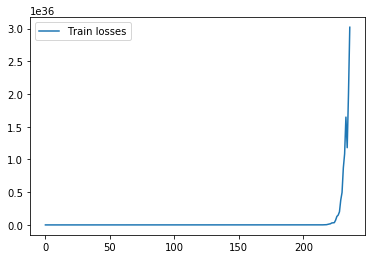

In [18]:
var_model = MLP_20(Vocab_size,20)
optimizer = torch.optim.SGD(var_model.parameters(),lr=0.2)
loss_func = nn.CrossEntropyLoss()
model, losses = train_5000(var_model,train_loader,optimizer,loss_func)
    

[3 7]
